## **Project Introduction - Bacteria Raman Classification**

Paper: ["Rapid identification of pathogenic bacteria using Raman spectroscopy and deep learning"](https://www.nature.com/articles/s41467-019-12898-9 )

Github (paper codebase): https://github.com/csho33/bacteria-ID/blob/master/README.md

Inspired by contemporary research in rapid bacterial identification, this project develops a complete machine learning pipeline to classify 30 bacterial species using Raman spectroscopy. The core of the project is a 1D Convolutional Neural Network (CNN) trained from scratch, which is subsequently adapted for clinical use cases via transfer learning.

The workflow follows three key stages:

1. Data Analysis: The project begins with data loading and a thorough Exploratory Data Analysis (EDA), leveraging visualization to verify the quality and characteristics of the spectral data.

2. Baseline Modeling: A benchmark for performance is established by implementing a traditional machine learning model using Principal Component Analysis (PCA) and a Support Vector Classifier (SVC).

3. Deep Learning: A sophisticated 1D CNN is built, trained, and evaluated on a large Raman dataset, forming the primary classification engine for this project.

**Model Building Process:**

PCA+SVC: baseline model accuracy = 0.414 on test data

model_1: single layer with Conv1D layer for tuning learning rate

model_2: single layer with Conv1D and optimal lr, accuracy = 0.481 on test data

model_3: multiple layers with Conv1D, accuracy = 0.537 on test data

model_finetune: fine-tuning on model_3, accuracy = 0.843 on test data

model_2018clinical: transfer learning on model_finetune, accuracy = 0.976 on 2018 clinical data

**Call predefined helper_functions**

In [ ]:
# Get predefined helper functions
!wget https://raw.githubusercontent.com/Eddiesunset0121/Bacteria-Raman-classification/main/src/helper_function.py

--2025-09-17 02:54:12--  https://raw.githubusercontent.com/Eddiesunset0121/Bacteria-Raman-classification/main/src/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11963 (12K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  11.68K  --.-KB/s    in 0s      

2025-09-17 02:54:12 (103 MB/s) - ‘helper_function.py’ saved [11963/11963]



**Check GPU status**

In [ ]:
!nvidia-smi

Wed Sep 17 02:54:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

**Setup and Installation**

In [ ]:
# Clone project repository to access the requirements file
!git clone https://github.com/Eddiesunset0121/Bacteria-Raman-classification.git

# Navigate into the cloned repository
%cd Bacteria-Raman-classification

# Install all dependencies from the requirements.txt file
!pip install -r requirements.txt

Cloning into 'Bacteria-Raman-classification'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 56 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 29.21 KiB | 2.43 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/Bacteria-Raman-classification
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.9/211.9 kB 4.1 MB/s eta 0:00:00


**Import Libraries**

In [ ]:
# Standard Library Imports
import random

# Third-Party Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pybaselines.whittaker import asls
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                     StandardScaler)
from sklearn.svm import SVC
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Activation, Add, BatchNormalization, Conv1D, Dense, Dropout, GlobalAveragePooling1D, Input, MaxPooling1D)
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm

# Local Application Imports
from helper_function import make_confusion_matrix, plot_loss_curves

##Loading data using Kaggle api

**Load data stored on Kaggle and unzip the data after importing**

In [ ]:
import os
from google.colab import userdata

# Get the Kaggle API key from Colab Secrets
kaggle_api_key = userdata.get('KAGGLE_JSON')

# Define the path for the kaggle.json file
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True) # Create the directory if it doesn't exist
kaggle_filepath = os.path.join(kaggle_dir, 'kaggle.json')

# Write the API key to the file
with open(kaggle_filepath, 'w') as f:
    f.write(kaggle_api_key)

# Set the correct permissions for the file
!chmod 600 {kaggle_filepath}

print("Kaggle API key configured successfully.")

# kaggle download command to doenload data
!kaggle datasets download -d eddie0121datascience/bacteria-raman-classification

# Unzip the data
!unzip bacteria-raman-classification.zip

Kaggle API key configured successfully.
Dataset URL: https://www.kaggle.com/datasets/eddie0121datascience/bacteria-raman-classification
License(s): unknown
bacteria-raman-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bacteria-raman-classification.zip
  inflating: X_2018clinical.npy      
  inflating: X_2019clinical.npy      
  inflating: X_finetune.npy          
  inflating: X_reference.npy         
  inflating: X_test.npy              
  inflating: wavenumbers.npy         
  inflating: y_2018clinical.npy      
  inflating: y_2019clinical.npy      
  inflating: y_finetune.npy          
  inflating: y_reference.npy         
  inflating: y_test.npy              


**Loading the datasets stored as np array**

The reference dataset consists of 30 bacterial and yeast isolates, including
multiple isolates of Gram-negative and Gram-positive bacteria, as well as Candida species, The reference training dataset consists of 2000 spectra each for the 30 reference isolates.

In [ ]:
# Loading reference (training) dataset
X = np.load("X_reference.npy")
y_float = np.load("y_reference.npy")
y = y_float.astype(np.int64)

# Loading test (independent form training) data set
X_test = np.load("X_test.npy")
y_test_float = np.load("y_test.npy")
y_test = y_test_float.astype(np.int64)

# Loading finetune datasets
X_finetune = np.load("X_finetune.npy")
y_finetune_float = np.load("y_finetune.npy")
y_finetune = y_finetune_float.astype(np.int64)

# Loading clinical datasets
X_2018clinical = np.load("X_2018clinical.npy")
y_2018clinical_float = np.load("y_2018clinical.npy")
y_2018clinical = y_2018clinical_float.astype(np.int64)

X_2019clinical = np.load("X_2019clinical.npy")
y_2019clinical_float = np.load("y_2019clinical.npy")
y_2019clinical = y_2019clinical_float.astype(np.int64)

# Loading wavenumber data as x-axis of a spectrum
wavenumbers = np.load("wavenumbers.npy")

# Lables representing each species
species_labels = [
          'MRSA 1 (isogenic)',
          'MRSA 2',
          'MSSA 1',
          'MSSA 2',
          'MSSA 3',
          'S. epidermidis',
          'S. lugdunensis',
          'S. pneumoniae 1',
          'S. pneumoniae 2',
          'Group A Strep.',
          'Group B Strep.',
          'Group C Strep.',
          'Group G Strep.',
          'S. sanguinis',
          'E. faecalis 1',
          'E. faecalis 2',
          'E. faecium',
          'E. coli 1',
          'E. coli 2',
          'K. pneumoniae 1',
          'K. pneumoniae 2',
          'K. aerogenes',
          'E. cloacae',
          'P. mirabilis',
          'S. marcescens',
          'S. enterica',
          'P. aeruginosa 1',
          'P. aeruginosa 2',
          'C. albicans',
          'C. glabrata'
          ]

**Check data types**

In [ ]:
# Checking datatypes of X
print(f"data type of X: {X.dtype}")
print(f"data type of X_finetune: {X_finetune.dtype}")
print(f"data type of X_2018clinical: {X_2018clinical.dtype}")
print(f"data type of X_2019clinical: {X_2019clinical.dtype}")
print()
# # Checking datatypes of y
print(f"data type of y: {y.dtype}")
print(f"data type of y_finetune: {y_finetune.dtype}")
print(f"data type of y_2018clinical: {y_2018clinical.dtype}")
print(f"data type of y_2019clinical: {y_2019clinical.dtype}")

data type of X: float64
data type of X_finetune: float64
data type of X_2018clinical: float64
data type of X_2019clinical: float64

data type of y: int64
data type of y_finetune: int64
data type of y_2018clinical: int64
data type of y_2019clinical: int64


**Prepare data using train_test_split**

Data for general training

- X_train
- X_val
- y_train
- y_val

In [ ]:
# 95%-5% train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True, stratify=y)

Data for fine-tuning (optical degradation)

- X_ft_train
- X_ft_val
- y_ft_train
- y_ft_val

In [ ]:
# 90%-10% train-validation split
X_ft_train, X_ft_val, y_ft_train, y_ft_val = train_test_split(
    X_finetune, # Convert from tensor to numpy for sklearn
    y_finetune,
    test_size=0.1,
    stratify=y_finetune,
    random_state=42)

Data for fine-tuning (clinical data in 2018)

- X_2018clinical_tune
- X_2018clinic_val
- X_2018clinic_test
- y_2018clinical_tune
- y_2018clinic_val
- y_2018clinic_test





In [ ]:
# Split the 2018 clinical data into its own fine-tuning, validation sets, and test sets
# 90&, 5&, 5% train-val-test split
X_2018clinical_tune, X_2018clinical_temp, y_2018clinical_tune, y_2018clinical_temp = train_test_split(
    X_2018clinical,
    y_2018clinical,
    test_size=0.1, # Use 10% of the clinical data for validation and test
    stratify=y_2018clinical,
    random_state=42)

X_2018clinical_val, X_2018clinical_test, y_2018clinical_val, y_2018clinical_test = train_test_split(
    X_2018clinical_temp,
    y_2018clinical_temp,
    test_size=0.5, # 5% validation and 5% test
    stratify=y_2018clinical_temp,
    random_state=42)

**Check the length of each dataset after splitting**



In [ ]:
print("General training dataset:")
print(f"length of X_train: {len(X_train)}")
print(f"length of y_train: {len(y_train)}")
print(f"length of X_val: {len(X_val)}")
print(f"length of y_val: {len(y_val)}\n")
print("Finetune dataset:")
print(f"length of X_ft_train: {len(X_ft_train)}")
print(f"length of y_ft_train: {len(y_ft_train)}")
print(f"length of X_ft_val: {len(X_ft_val)}")
print(f"length of y_ft_val: {len(y_ft_val)}\n")
print("Test dataset:")
print(f"length of X_test: {len(X_test)}")
print(f"length of y_test: {len(y_test)}\n")
print("Clinical dataset 2018:")
print(f"length of X_2018clinical_tune: {len(X_2018clinical_tune)}")
print(f"length of y_2018clinical_tune: {len(y_2018clinical_tune)}")
print(f"length of X_2018clinical_val: {len(X_2018clinical_val)}")
print(f"length of y_2018clinical_val: {len(y_2018clinical_val)}")
print(f"length of X_2018clinical_test: {len(X_2018clinical_test)}")
print(f"length of y_2018clinical_test: {len(y_2018clinical_test)}")

General training dataset:
length of X_train: 57000
length of y_train: 57000
length of X_val: 3000
length of y_val: 3000

Finetune dataset:
length of X_ft_train: 2700
length of y_ft_train: 2700
length of X_ft_val: 300
length of y_ft_val: 300

Test dataset:
length of X_test: 3000
length of y_test: 3000

Clinical dataset 2018:
length of X_2018clinical_tune: 9000
length of y_2018clinical_tune: 9000
length of X_2018clinical_val: 500
length of y_2018clinical_val: 500
length of X_2018clinical_test: 500
length of y_2018clinical_test: 500


**Check the shape of each tensor**

In [ ]:
# Checking the shape of the data
print("General training dataset:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}\n")

print("Finetune dataset:")
print(f"Shape of X_ft_train: {X_ft_train.shape}")
print(f"Shape of y_ft_train: {y_ft_train.shape}")
print(f"Shape of X_ft_val: {X_ft_val.shape}")
print(f"Shape of y_ft_val: {y_ft_val.shape}\n")

print("Test dataset:")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}\n")

print("Clinical dataset 2018:")
print(f"Shape of X_2018clinical_tune: {X_2018clinical_tune.shape}")
print(f"Shape of y_2018clinical_tune: {y_2018clinical_tune.shape}")
print(f"Shape of X_2018clinical_val: {X_2018clinical_val.shape}")
print(f"Shape of y_2018clinical_val: {y_2018clinical_val.shape}")
print(f"Shape of X_2018clinical_test: {X_2018clinical_test.shape}")
print(f"Shape of y_2018clinical_test: {y_2018clinical_test.shape}\n")

print(f"wavenumber: {wavenumbers.shape}")

General training dataset:
Shape of X_train: (57000, 1000)
Shape of y_train: (57000,)
Shape of X_val: (3000, 1000)
Shape of y_val: (3000,)

Finetune dataset:
Shape of X_ft_train: (2700, 1000)
Shape of y_ft_train: (2700,)
Shape of X_ft_val: (300, 1000)
Shape of y_ft_val: (300,)

Test dataset:
Shape of X_test: (3000, 1000)
Shape of y_test: (3000,)

Clinical dataset 2018:
Shape of X_2018clinical_tune: (9000, 1000)
Shape of y_2018clinical_tune: (9000,)
Shape of X_2018clinical_val: (500, 1000)
Shape of y_2018clinical_val: (500,)
Shape of X_2018clinical_test: (500, 1000)
Shape of y_2018clinical_test: (500,)

wavenumber: (1000,)


## Exploratory Analysis of Spectral Quality

**Visualize number of classes in training data**

In [ ]:
# Examine number of data for each species
count_classes = pd.DataFrame(y_train)
count_classes.value_counts()

0 
0     1900
1     1900
2     1900
3     1900
4     1900
5     1900
6     1900
7     1900
8     1900
9     1900
10    1900
11    1900
12    1900
13    1900
14    1900
15    1900
16    1900
17    1900
18    1900
19    1900
20    1900
21    1900
22    1900
23    1900
24    1900
25    1900
26    1900
27    1900
28    1900
29    1900
Name: count, dtype: int64

The number of species in the traiining data is perfectly balanced with 2000 data for each species

**Visualize number of classes in test and valdation data**

In [ ]:
# Count classes in the validation set
unique_classes_val, counts_val = np.unique(y_val, return_counts=True)
print("Validation Set Class Counts:")
print(np.asarray((unique_classes_val, counts_val)).T)

print("-" * 30)

# Count classes in the test set
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)
print("Test Set Class Counts:")
print(np.asarray((unique_classes_test, counts_test)).T)

Validation Set Class Counts:
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5 100]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]
 [ 10 100]
 [ 11 100]
 [ 12 100]
 [ 13 100]
 [ 14 100]
 [ 15 100]
 [ 16 100]
 [ 17 100]
 [ 18 100]
 [ 19 100]
 [ 20 100]
 [ 21 100]
 [ 22 100]
 [ 23 100]
 [ 24 100]
 [ 25 100]
 [ 26 100]
 [ 27 100]
 [ 28 100]
 [ 29 100]]
------------------------------
Test Set Class Counts:
[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5 100]
 [  6 100]
 [  7 100]
 [  8 100]
 [  9 100]
 [ 10 100]
 [ 11 100]
 [ 12 100]
 [ 13 100]
 [ 14 100]
 [ 15 100]
 [ 16 100]
 [ 17 100]
 [ 18 100]
 [ 19 100]
 [ 20 100]
 [ 21 100]
 [ 22 100]
 [ 23 100]
 [ 24 100]
 [ 25 100]
 [ 26 100]
 [ 27 100]
 [ 28 100]
 [ 29 100]]


The number of species in the test and valodation data is perfectly balanced with 100 data for each species as a result of setting "stratify" parameter in train_test_split

**Select a random species and then randomly sample 5 spectra from that species**

Examine if the data quality acquired meets the following criretia:
* Baseline corrected
* Removal of comic rays
* Area of spectrum normalized

Randomly selected species: P. aeruginosa 2


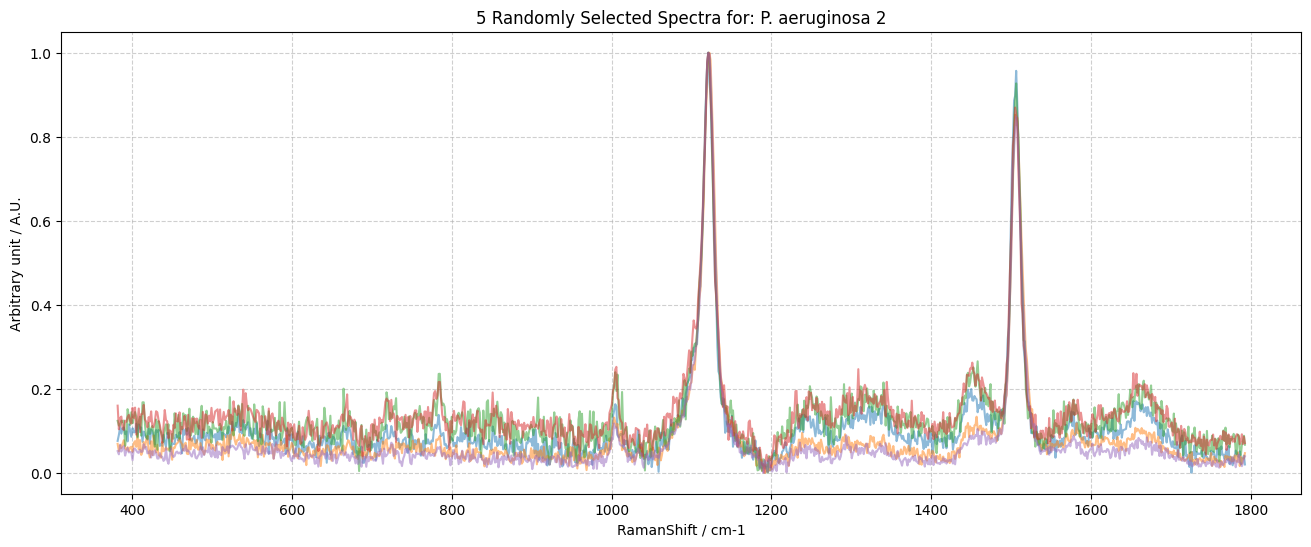

In [ ]:
# Generate a random number for the index of species_labels
random_species_index = random.randint(0,29)

# Using random index to select the species labels
random_species_labels = species_labels[random_species_index]

# Create a dataframe of spectrum for selection based on randonly selected species_labels
spectrum_all_df = pd.DataFrame(X_train)
spectrum_random_df = spectrum_all_df[y_train == random_species_index]
print(f"Randomly selected species: {random_species_labels}")

# Generate 5 random index in spectrum_random_df (size=2000)
random_spectrum_index = random.sample(range(0,1400),5)

# Select five spectrum from a randomly selected species
final_random_spectrum_df = spectrum_random_df.iloc[random_spectrum_index]

# Disaply the random_spectrum with wavenumbers
# transpose the row(spectrum) and loop through each columns
plt.figure(figsize = (16,6))
for spectrum_column in final_random_spectrum_df.T:
  plt.plot(wavenumbers, final_random_spectrum_df.T[spectrum_column], alpha = 0.5)
plt.xlabel("RamanShift / cm-1")
plt.ylabel("Arbitrary unit / A.U.")
plt.title(f"5 Randomly Selected Spectra for: {random_species_labels}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Compare the mean spectrum for each species to see if baseline correction is needed**

In [ ]:
def check_raw_data():
    # List of the actual data arrays
    raw_X_data_list = [
        X_train,
        X_test,
        X_val,
        X_finetune,
        X_2018clinical,
        X_2019clinical
     ]
    # List of the actual label arrays
    raw_y_data_list = [y_train, y_test, y_val, y_finetune, y_2018clinical, y_2019clinical]

    # A new list containing the names (strings) for the plot titles
    dataset_names = [
        "Training Set",
        "Test Set",
        "Validation Set",
        "Finetune Set",
        "2018 Clinical Set",
        "2019 Clinical Set"
    ]

    # Pick a random index from 0 to the number of datasets
    random_index = random.randint(0, len(dataset_names) - 1)

    # Use the same random index to get the corresponding data, labels, and name
    random_baseline_corrected_data = raw_X_data_list[random_index]
    random_y_data = raw_y_data_list[random_index]
    dataset_name = dataset_names[random_index]

    plt.figure(figsize=(20, 8))

    for class_index in range(30):
        class_spectra = random_baseline_corrected_data[random_y_data == class_index]
        if class_spectra.shape[0] > 0:
            mean_spectrum = np.mean(class_spectra, axis=0)
            plt.plot(wavenumbers, mean_spectrum, label=species_labels[class_index], alpha=0.6)

    plt.xlabel("RamanShift / cm⁻¹", fontsize=12)
    plt.ylabel("Mean Intensity / A.U.", fontsize=12)

    # Use the selected 'dataset_name' string for a clean title
    plt.title(f"Mean Raw Raman Spectra: {dataset_name} for All 30 Bacterial Species", fontsize=16)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

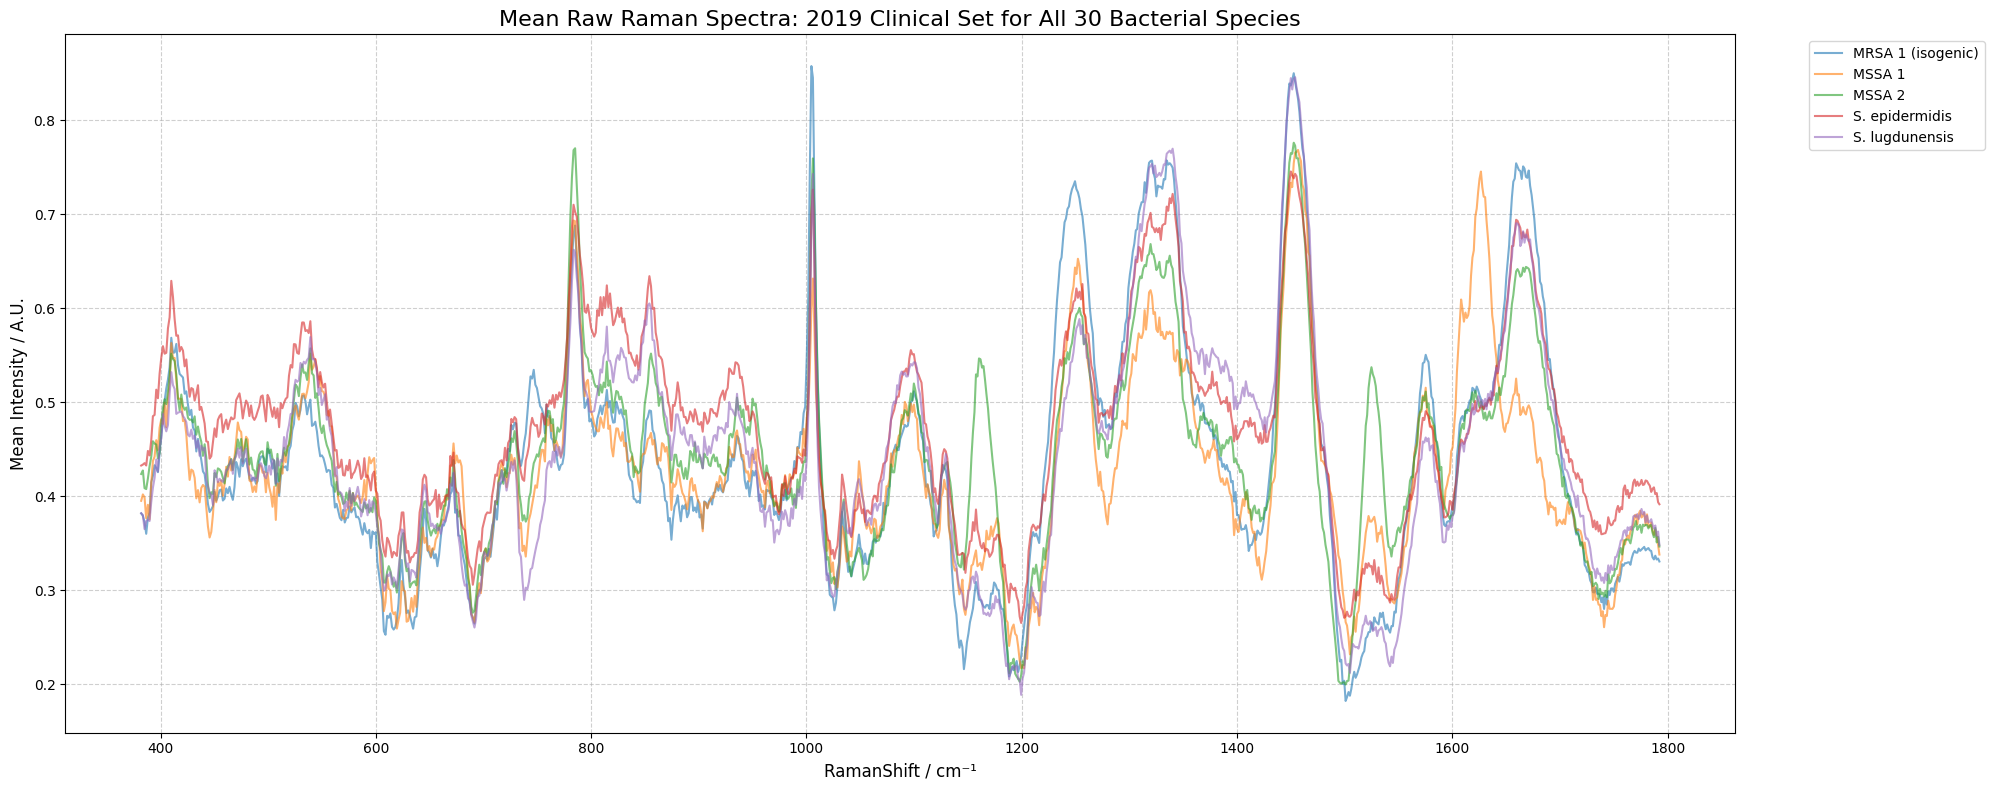

In [ ]:
check_raw_data()

As conformed by the mean spectrum for each species, they are baseline corrected, and comic rays are remved, therefore, no preprocessing should be performed in data preprocessing steps

**Key findings**: 🔔

1. The training data is ordered, for example, the first 1400 spectra belongs to one bacteria species, the second 1400 spetra belong to another bacteria species

2. Since the training data is not randomly ordered, the model will update the weight from each batch corersponding to different species, causing the model's learning process to oscillate wildly instead of smoothly converging to a good solution. Therefore 🔑🔑**training data need to be "shuffled" in the training process**. 🔑🔑

3. Validation data does not need to be shuffled because it serves as fixed, consistent benchmark for validation

**Reshape the data**

A Conv1D layer in TensorFlow/Keras is designed to work with 3D input tensors that have the shape (samples, timesteps, features).

Our raw spectral data has a 2D shape of (samples, timesteps), where each timestep is a single intensity value. To make it compatible, we must add a final dimension for the "features". A perfect analogy is the input to a Conv2D layer for an image, which has a shape like (width, height, channels).The 3 channels in a (224, 224, 3) image represent the Red, Green, and Blue features at each pixel. Similarly, the 1 channel we are adding to our spectral data, creating a shape of (1000, 1), represents the single "intensity channel" at each wavenumber.

This reshaping is a necessary formatting step that makes the data's structure unambiguous for the Conv1D layer.

In [ ]:
# Reahspe X data by adding extra dimension at the endof each data
# General training dataset
X_train_final = tf.expand_dims(X_train, axis = -1) # Add a dimension at the end
X_val_final = tf.expand_dims(X_val, axis = -1)  # Add a dimension at the end

# Finetune dataset
X_ft_train_final = tf.expand_dims(X_ft_train, axis = -1) # Add a dimension at the end
X_ft_val_final = tf.expand_dims(X_ft_val, axis = -1) # Add a dimension at the end

# Test dataset
X_test_final = tf.expand_dims(X_test, axis = -1)  # Add a dimension at the end

# Clinical dataset 2018
X_2018clinical_tune_final = tf.expand_dims(X_2018clinical_tune, axis = -1)  # Add a dimension at the end
X_2018clinical_val_final = tf.expand_dims(X_2018clinical_val, axis = -1)  # Add a dimension at the end
X_2018clinical_test_final = tf.expand_dims(X_2018clinical_test, axis = -1)  # Add a dimension at the end

# Clinical dataset 2019
X_2019clinical_final = tf.expand_dims(X_2019clinical, axis = -1)  # Add a dimension at the end

# Examine if X data has been reshaped
print(f"shape of X_train_final: {X_train_final.shape}")
print(f"shape of X_val_final: {X_val_final.shape}")
print(f"shape of X_test_final: {X_test_final.shape}")
print(f"shape of X_ft_train_final: {X_ft_train_final.shape}")
print(f"shape of X_ft_val_final: {X_ft_val_final.shape}")
print(f"shape of X_2018clinical_tune_final: {X_2018clinical_tune_final.shape}")
print(f"shape of X_2018clinical_val_final: {X_2018clinical_val_final.shape}")
print(f"shape of X_2018clinical_test_final: {X_2018clinical_test_final.shape}")
print(f"shape of X_2019clinical_final: {X_2019clinical_final.shape}")

shape of X_train_final: (57000, 1000, 1)
shape of X_val_final: (3000, 1000, 1)
shape of X_test_final: (3000, 1000, 1)
shape of X_ft_train_final: (2700, 1000, 1)
shape of X_ft_val_final: (300, 1000, 1)
shape of X_2018clinical_tune_final: (9000, 1000, 1)
shape of X_2018clinical_val_final: (500, 1000, 1)
shape of X_2018clinical_test_final: (500, 1000, 1)
shape of X_2019clinical_final: (2500, 1000, 1)


In [ ]:
def check_final_X_data():
    # List of the actual data arrays
    baseline_corrected_data_list = [
        X_train_final,
        X_test_final,
        X_val_final,
        X_ft_train_final,
        X_ft_val_final,
        X_2018clinical_tune_final,
        X_2018clinical_val_final,
        X_2018clinical_test_final,
        X_2019clinical_final
     ]
    # List of the actual label arrays
    y_data_list = [y_train,
            y_test,
            y_val,
            y_ft_train,
            y_ft_val,
            y_2018clinical_tune,
            y_2018clinical_val,
            y_2018clinical_test,
            y_2019clinical]

    # A new list containing the names (strings) for the plot titles
    dataset_names = [
        "Training Set",
        "Test Set",
        "Validation Set",
        "Finetune Train Set",
        "Finetune Validation Set",
        "2018 Clinical Tune Set",
        "2018 Clinical Validation Set",
        "2018 Clinical Test Set",
        "2019 Clinical Set"
    ]

    # Pick a random index from 0 to the number of datasets
    random_index = random.randint(0, len(dataset_names) - 1)

    # Use the same random index to get the corresponding data, labels, and name
    random_baseline_corrected_data = baseline_corrected_data_list[random_index]
    random_y_data = y_data_list[random_index]
    dataset_name = dataset_names[random_index]

    plt.figure(figsize=(20, 8))

    for class_index in range(30):
        class_spectra = random_baseline_corrected_data[random_y_data == class_index]
        if class_spectra.shape[0] > 0:
            mean_spectrum = np.mean(class_spectra, axis=0)
            plt.plot(wavenumbers, mean_spectrum, label=species_labels[class_index], alpha=0.6)

    plt.xlabel("RamanShift / cm⁻¹", fontsize=12)
    plt.ylabel("Mean Intensity / A.U.", fontsize=12)

    # Use the selected 'dataset_name' string for a clean title
    plt.title(f"Final Raman Spectra: {dataset_name} for All 30 Bacterial Species", fontsize=16)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

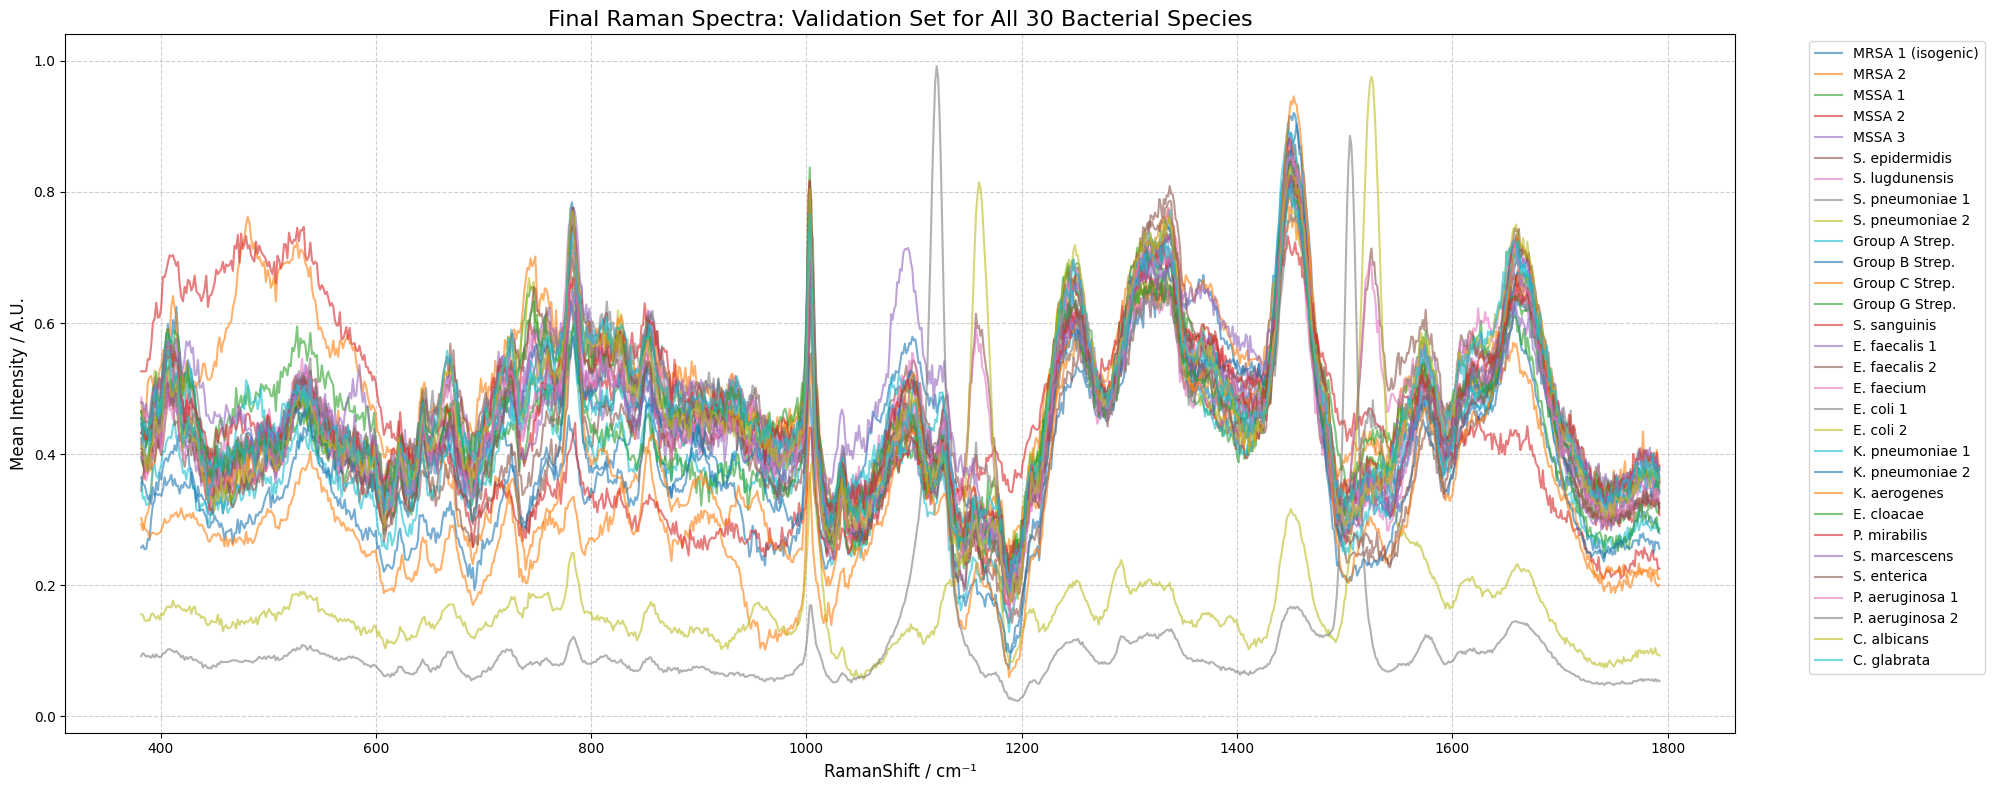

In [ ]:
check_final_X_data()

**One-hot-encoding labels**

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
# sparse_output=False ensures the output is a dense NumPy array instead of a sparse matrix

# Shape before reshaping
print("Original y data:")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_val: {y_val.shape}")
print(f"shape of y_test: {y_test.shape}")
print(f"shape of y_ft_train: {y_ft_train.shape}")
print(f"shape of y_ft_val: {y_ft_val.shape}")
print(f"shape of y_2018clinical_tune: {y_2018clinical_tune.shape}")
print(f"shape of y_2018clinical_val: {y_2018clinical_val.shape}")
print(f"shape of y_2018clinical_test: {y_2018clinical_test.shape}")
print(f"shape of y_2019clinical: {y_2019clinical.shape}\n")

# Reshape y data
# The scikit-learn OneHotEncoder expects a 2D input array with the shape: (n_samples, n_features)
y_train_reshaped = y_train.reshape(-1,1)
y_val_reshaped = y_val.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_ft_train_reshaped = y_ft_train.reshape(-1,1)
y_ft_val_reshaped = y_ft_val.reshape(-1,1)
y_2018clinical_tune_reshaped = y_2018clinical_tune.reshape(-1,1)
y_2018clinical_val_reshaped = y_2018clinical_val.reshape(-1,1)
y_2018clinical_test_reshaped = y_2018clinical_test.reshape(-1,1)
y_2019clinical_reshaped = y_2019clinical.reshape(-1,1)

# Checking if reshape is successful
print("Reshaped y data:")
print(f"shape of y_train_reshaped: {y_train_reshaped.shape}")
print(f"shape of y_val_reshaped: {y_val_reshaped.shape}")
print(f"shape of y_test_reshaped: {y_test_reshaped.shape}")
print(f"shape of y_ft_train_reshaped: {y_ft_train_reshaped.shape}")
print(f"shape of y_ft_val_reshaped: {y_ft_val_reshaped.shape}")
print(f"shape of y_2018clinical_tune_reshaped: {y_2018clinical_tune_reshaped.shape}")
print(f"shape of y_2018clinical_val_reshaped: {y_2018clinical_val_reshaped.shape}")
print(f"shape of y_2018clinical_test_reshaped: {y_2018clinical_test_reshaped.shape}")
print(f"shape of y_2019clinical_reshaped: {y_2019clinical_reshaped.shape}\n")

# fit_transform() to perform parameter learning and data transformation in a single step
# fit and transform on training data (30 classes)
y_train_final = encoder.fit_transform(y_train_reshaped)

# Only transform the validation and test data (precvent data leakage)
y_val_final = encoder.transform(y_val_reshaped)
y_test_final = encoder.transform(y_test_reshaped)
y_ft_train_final = encoder.transform(y_ft_train_reshaped)
y_ft_val_final = encoder.transform(y_ft_val_reshaped)

# fit and transform on training data (5 classes)
y_2018clinical_tune_final = encoder.fit_transform(y_2018clinical_tune_reshaped)

# Only transform the validation and test data (precvent data leakage)
y_2018clinical_val_final = encoder.transform(y_2018clinical_val_reshaped)
y_2018clinical_test_final = encoder.transform(y_2018clinical_test_reshaped)
y_2019clinical_final = encoder.transform(y_2019clinical_reshaped)

# Checking the shape of final y data
print("Final One-hot encoded y data:")
print(f"shape of y_train_final: {y_train_final.shape}")
print(f"shape of y_val_final: {y_val_final.shape}")
print(f"shape of y_test_final: {y_test_final.shape}")
print(f"shape of y_ft_train_final: {y_ft_train_final.shape}")
print(f"shape of y_ft_val_final: {y_ft_val_final.shape}")
print(f"shape of y_2018clinical_tune_final: {y_2018clinical_tune_final.shape}")
print(f"shape of y_2018clinical_val_final: {y_2018clinical_val_final.shape}")
print(f"shape of y_2018clinical_test_final: {y_2018clinical_test_final.shape}")
print(f"shape of y_2019clinical_final: {y_2019clinical_final.shape}\n")

# Checking if one-hot-encoding is successful
print(f"y_train_final:\n\n {y_train_final}\n")
print(f"y_val_final:\n\n {y_val_final}\n")
print(f"y_test_final:\n\n {y_test_final}\n")
print(f"y_ft_val_final:\n\n {y_ft_val_final}\n")
print(f"y_2018clinical_tune_final:\n\n {y_2018clinical_tune_final}\n")
print(f"y_2018clinical_tune_final:\n\n {y_2018clinical_tune_final}\n")
print(f"y_2018clinical_val_final:\n\n {y_2018clinical_val_final}\n")
print(f"y_2018clinical_test_final:\n\n {y_2018clinical_test_final}\n")
print(f"y_2019clinical_final:\n\n {y_2019clinical_final}\n")

Original y data:
shape of y_train: (57000,)
shape of y_val: (3000,)
shape of y_test: (3000,)
shape of y_ft_train: (2700,)
shape of y_ft_val: (300,)
shape of y_2018clinical_tune: (9000,)
shape of y_2018clinical_val: (500,)
shape of y_2018clinical_test: (500,)
shape of y_2019clinical: (2500,)

Reshaped y data:
shape of y_train_reshaped: (57000, 1)
shape of y_val_reshaped: (3000, 1)
shape of y_test_reshaped: (3000, 1)
shape of y_ft_train_reshaped: (2700, 1)
shape of y_ft_val_reshaped: (300, 1)
shape of y_2018clinical_tune_reshaped: (9000, 1)
shape of y_2018clinical_val_reshaped: (500, 1)
shape of y_2018clinical_test_reshaped: (500, 1)
shape of y_2019clinical_reshaped: (2500, 1)

Final One-hot encoded y data:
shape of y_train_final: (57000, 30)
shape of y_val_final: (3000, 30)
shape of y_test_final: (3000, 30)
shape of y_ft_train_final: (2700, 30)
shape of y_ft_val_final: (300, 30)
shape of y_2018clinical_tune_final: (9000, 5)
shape of y_2018clinical_val_final: (500, 5)
shape of y_2018clin

## Model building and training


For this project, a 1D CNN architecture is applied because it is specifically designed to analyze sequential data where local patterns are the most important features.

1. Spectra as Sequential Data: A Raman spectrum is a perfect example of 1D sequential data. It's a sequence of intensity values ordered along a single dimension—the wavenumber. The relationship between adjacent points is critical.

2. Filters as Peak Detectors: The key components of a 1D CNN are its filters (kernels), which act as small, sliding "pattern detectors." During training, these filters automatically learn to recognize the fundamental shapes within a spectrum that are most useful for classification, such as:

* The rising and falling edges of a peak

* The shape and width of a peak

* The relative intensity of adjacent peaks

3. Preserving Spatial Information: Unlike a standard dense (fully connected) network that treats every intensity point independently, a 1D CNN's convolutional nature preserves the spatial (wavenumber) relationship between neighboring data points. This is essential because the chemical information in a spectrum is encoded in the shape and position of these local features.

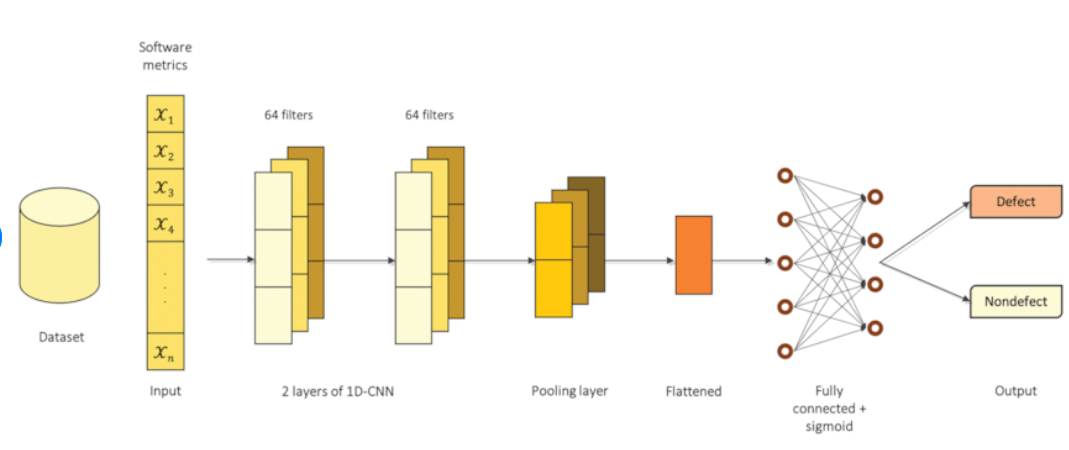

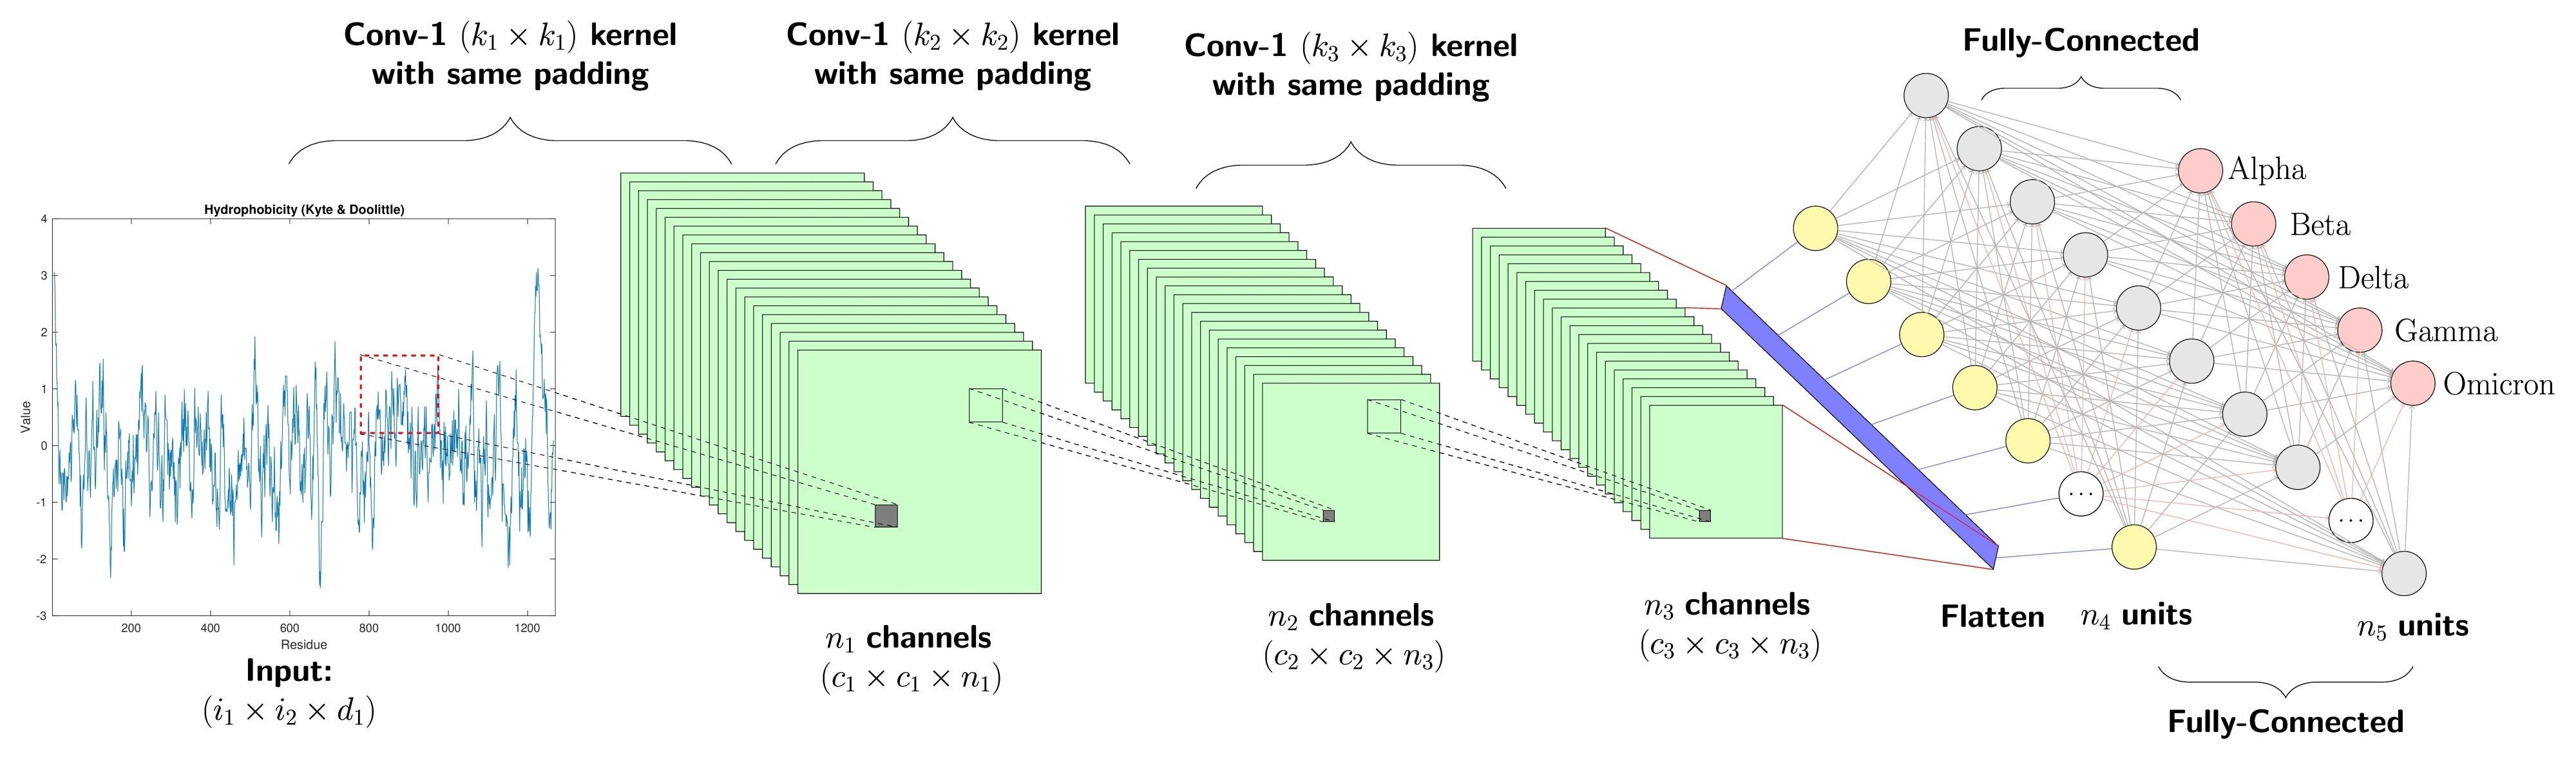

### Build a baseline model

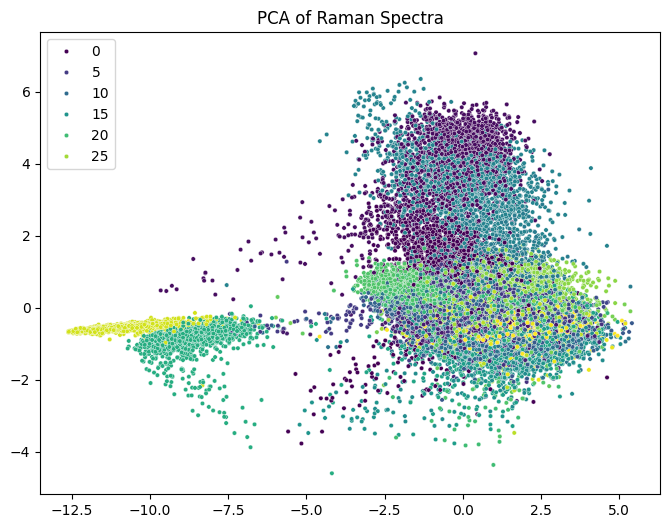

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train) # Using preprocessed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis', s=10)
plt.title('PCA of Raman Spectra')
plt.show()

In [ ]:
# Build a baseline model using PCA method
baseline_model = Pipeline([('pca', PCA(n_components = 20)),
              ('svc', SVC(kernel='rbf'))])

# Fit the baseline model with training and test datasets
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=20)), ('svc', SVC())])

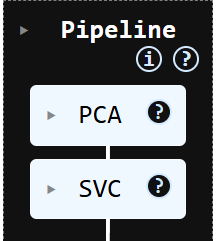

In [ ]:
# Evaluate the baseline_model
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy of baseline model: {baseline_accuracy:.3f}")

Accuracy of baseline model: 0.414


### 1D-CNN Model Building and Training

In [ ]:
# Checking the shape of the input data
# (batch_size, sequence_length, num_features)
X_train_final.shape

TensorShape([57000, 1000, 1])

Input shape of ID-CNN model:(batch_size, sequence_length, num_features)

batch_size: The number of samples in a single batch.
sequence_length: The length of the 1D sequence (e.g., number of time steps in a time series, number of words in a text sequence).

num_features: The number of features or channels for each element in the sequence (e.g., if you have multiple sensor readings at each time step, or word embeddings with a certain dimension).

**Create the first simple CNN model - Model_1**

In [ ]:
# Define input_shape usign a global variable
INPUT_SHAPE = X_train_final.shape[1:]
print(f"Input shape of the model: {INPUT_SHAPE}")

# Set random seed
tf.random.set_seed(42)

Input shape of the model: (1000, 1)


In [ ]:
# Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 10, kernel_size = 3, strides = 2, activation = "relu", input_shape = INPUT_SHAPE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation = "softmax")
    ])
# Create a learning rate callback to find optimal learning rate
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/20))

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy'])

# Summary of the model
model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)              │ (None, 499, 10)        │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 4990)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 30)             │       149,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,770 (585.04 KB)

 Trainable params: 149,770 (585.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
history_1 = model_1.fit(x = X_train_final,
             y = y_train_final,
             epochs = 100,
             batch_size = 32,
             validation_data = (X_val_final, y_val_final),
             shuffle = True,
             callbacks = [lr_scheduler],
             verbose = 0)

In [ ]:
# Visulaize all learning rates
lrs = 1e-4*10**(tf.range(100)/20)
lrs

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([1.00000000e-04, 1.12201845e-04, 1.25892541e-04, 1.41253754e-04,
       1.58489319e-04, 1.77827941e-04, 1.99526231e-04, 2.23872114e-04,
       2.51188643e-04, 2.81838293e-04, 3.16227766e-04, 3.54813389e-04,
       3.98107171e-04, 4.46683592e-04, 5.01187234e-04, 5.62341325e-04,
       6.30957344e-04, 7.07945784e-04, 7.94328235e-04, 8.91250938e-04,
       1.00000000e-03, 1.12201845e-03, 1.25892541e-03, 1.41253754e-03,
       1.58489319e-03, 1.77827941e-03, 1.99526231e-03, 2.23872114e-03,
       2.51188643e-03, 2.81838293e-03, 3.16227766e-03, 3.54813389e-03,
       3.98107171e-03, 4.46683592e-03, 5.01187234e-03, 5.62341325e-03,
       6.30957344e-03, 7.07945784e-03, 7.94328235e-03, 8.91250938e-03,
       1.00000000e-02, 1.12201845e-02, 1.25892541e-02, 1.41253754e-02,
       1.58489319e-02, 1.77827941e-02, 1.99526231e-02, 2.23872114e-02,
       2.51188643e-02, 2.81838293e-02, 3.16227766e-02, 3.54813389e-02,
       3.98107171e-02, 4.4668

Text(0.5, 1.0, 'Loss vs, Learning Rate')

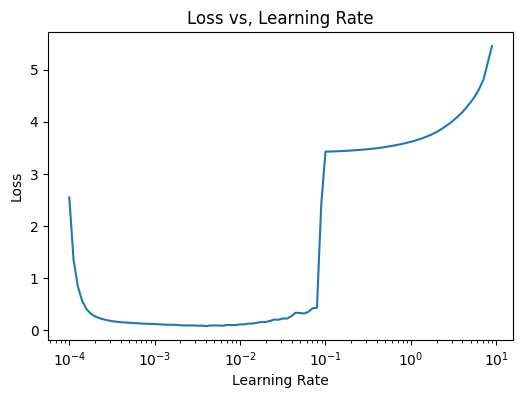

In [ ]:
# Plot loss vs. learning_rate(lrs) to find the optimal learning_rate
plt.figure(figsize = (6,4))
plt.semilogx(lrs, history_1.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs, Learning Rate")

The learning rate of 1e-3 was selected using a Learning Rate Range Test. This value corresponds to the point of steepest descent on the loss vs. learning rate plot, ensuring a balance between fast convergence and training stability.

In [ ]:
# Setting learning rate
LEARNING_RATE = 1e-3

# Setting random state
tf.random.set_seed(42)

**Improve model by using optimal learning rate - Model_2**

In [ ]:
# Create a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 10, kernel_size = 10, strides = 2, activation = "relu", input_shape = INPUT_SHAPE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation = "softmax")
    ])

# Add model checkpoints
model_checkpoint_2 = ModelCheckpoint('best_model_2.keras', save_best_only=True, monitor='val_loss')

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        metrics = ['accuracy'])

# Summary of the model
model_2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_81 (Conv1D)              │ (None, 496, 10)        │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 4960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 30)             │       148,830 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,940 (581.80 KB)

 Trainable params: 148,940 (581.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
history_2 = model_2.fit(x = X_train_final,
             y = y_train_final,
             epochs = 20,
             batch_size = 10,
             validation_data = (X_val_final, y_val_final),
             shuffle = True,
             callbacks = [model_checkpoint_2],
             verbose = 0)

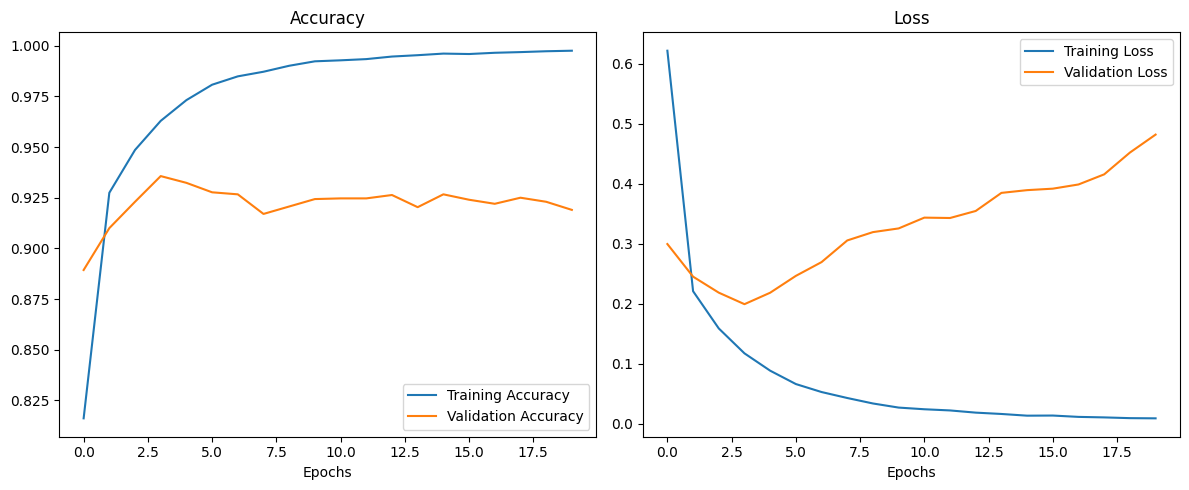

In [ ]:
plot_loss_curves(history_2)

**Evaluate model_2 on test data**

In [ ]:
# Evaluate the model after fine-tuning
print("Evaluating the model_2 on the test set...")

# Make predictions on the test data
best_model_2 = tf.keras.models.load_model('best_model_2.keras')
y_pred_2 = best_model_2.predict(X_test_final)

# Convert predictions from probabilities to class labels
y_pred_labels_2 = tf.argmax(y_pred_2, axis=1)

# Note: The original y_test labels are not one-hot encoded, so we use them directly.
accuracy_model_2 = accuracy_score(y_test, y_pred_labels_2)

print(f"\nAccuracy of model_2 on Test Set: {accuracy_model_2:.3f}")

Evaluating the model_2 on the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy of model_2 on Test Set: 0.488


**Make confusion matrix**

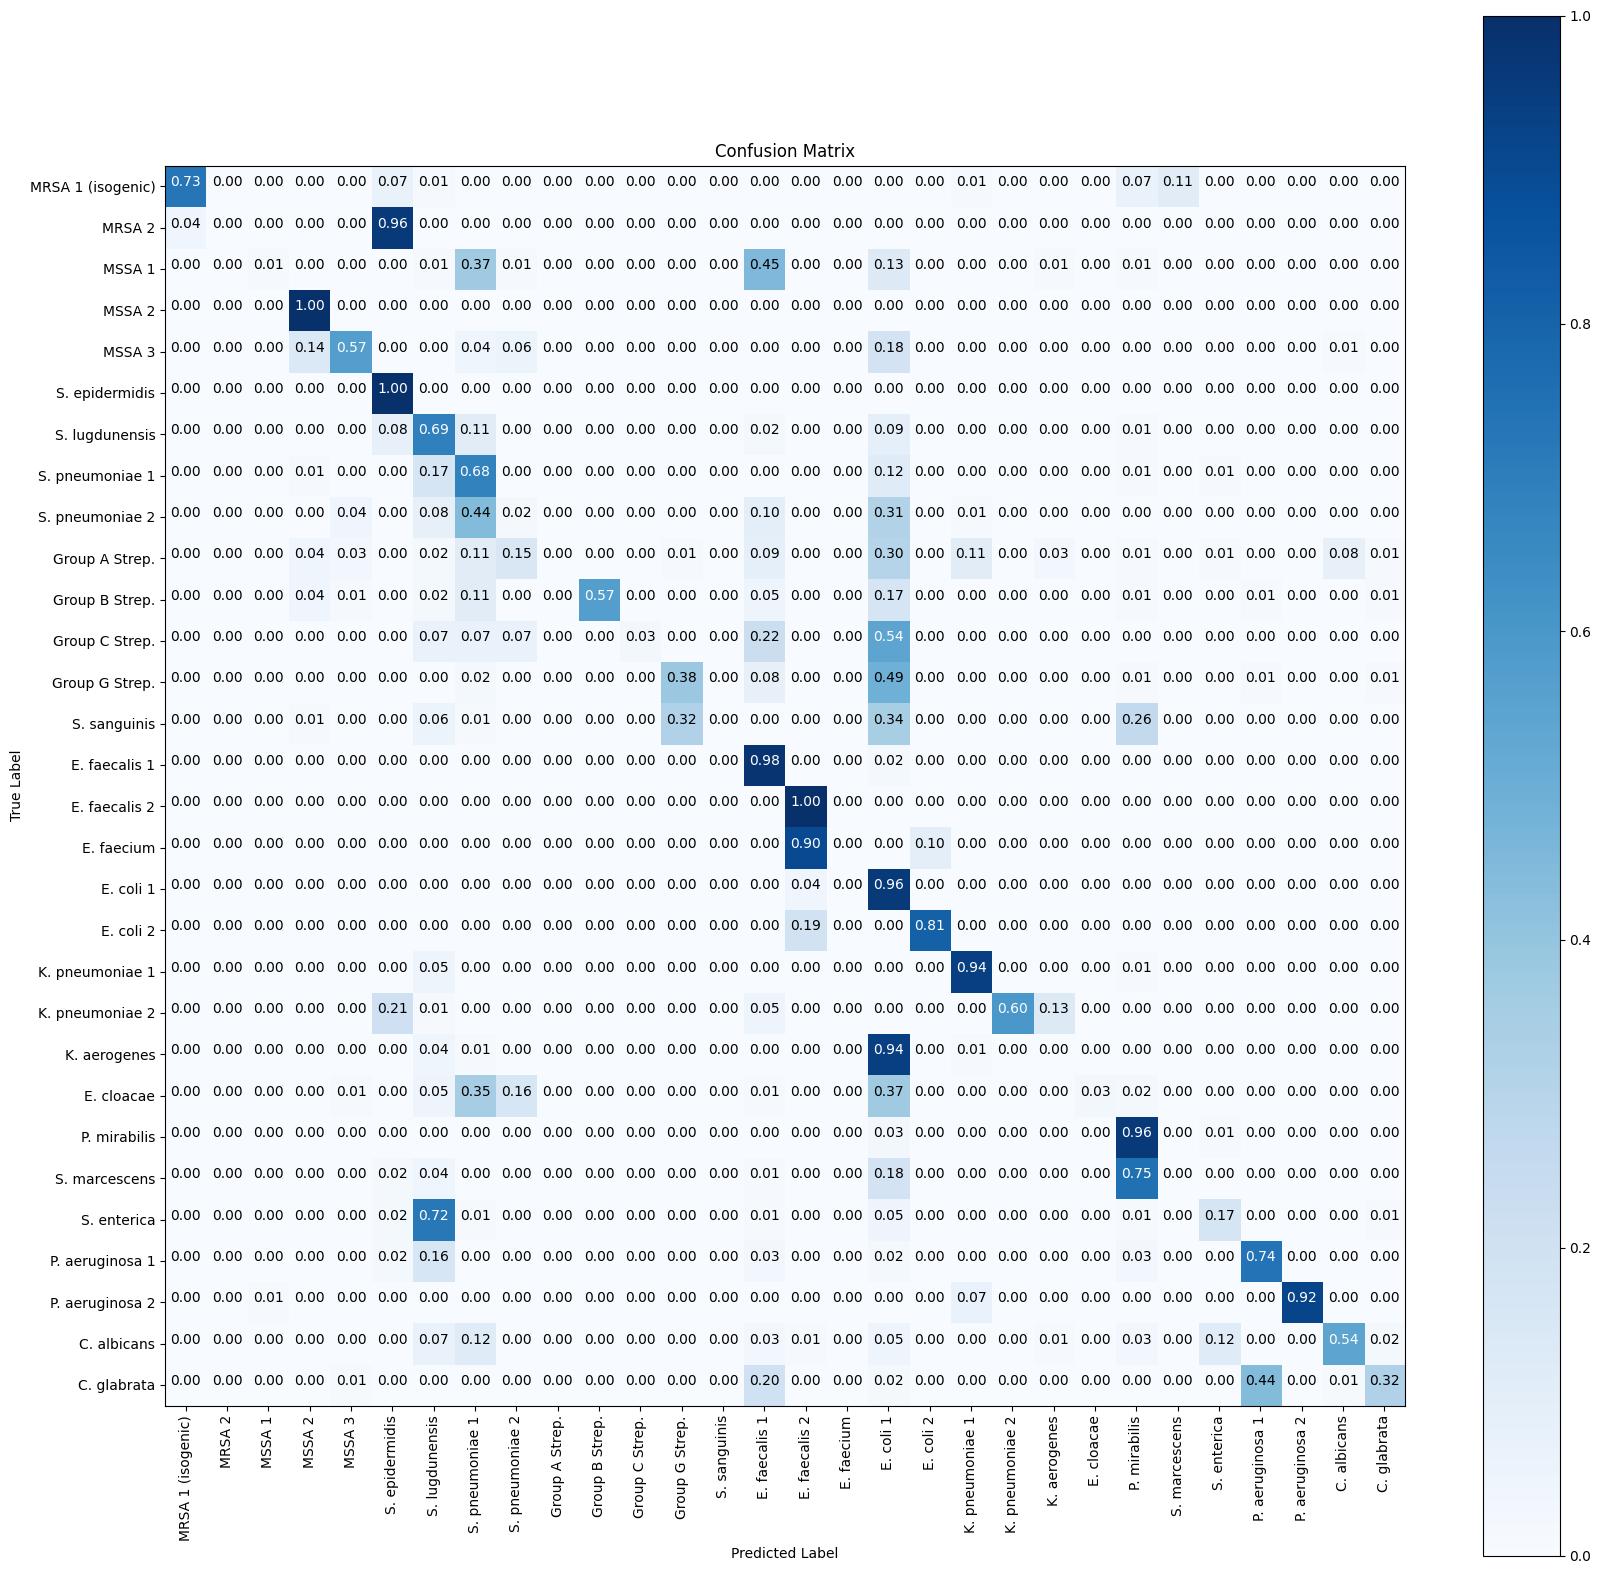

In [ ]:
# Example call to get percentages
make_confusion_matrix(y_test, y_pred_labels_2, classes=species_labels, normalize=True, figsize=(20,20), text_size = 10)

In the confisuin matrix, it's clear that ('E. faecalis 2', 'E. faecium')  and (('P. mirabilis', 'S. marcescens',)are completely indistinguishable by this simple model_2, let's compare the spectrum of these 2 pairs by visualization (put them in one fifure for easy comparison)

In [ ]:
# Create a fuunction to cpmpare mean sepctrum of 2 different species
def compare_mean_spectrum(class_1, class_2, X_data, y_data, species_labels_list, wavenumbers_data):
    """
    Compares the mean Raman spectra of two specified bacterial classes.
    """
    # Create a DataFrame from the spectral data, squeezing it from 3D to 2D
    df = pd.DataFrame(np.squeeze(X_data, axis=-1))

    # Get the integer index for each species name
    species_index_1 = species_labels_list.index(class_1)
    species_index_2 = species_labels_list.index(class_2)

    # Filter the DataFrame to get spectra for each class
    df_class_1 = df[y_data == species_index_1]
    df_class_2 = df[y_data == species_index_2]

    # --- Plotting ---
    plt.figure(figsize=(12, 4))

    # Plot the mean spectrum for each class
    plt.plot(wavenumbers_data, df_class_1.mean(), label=class_1)
    plt.plot(wavenumbers_data, df_class_2.mean(), label=class_2)

    # Add plot details
    plt.title(f"Spectrum Comparison of '{class_1}' and '{class_2}'")
    plt.xlabel("Raman Shift / $cm^{-1}$")
    plt.ylabel("Mean Intensity / A.U.")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

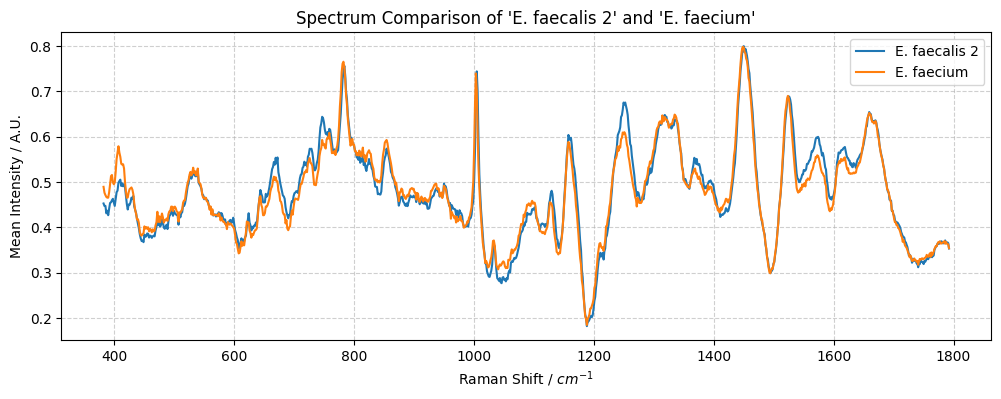

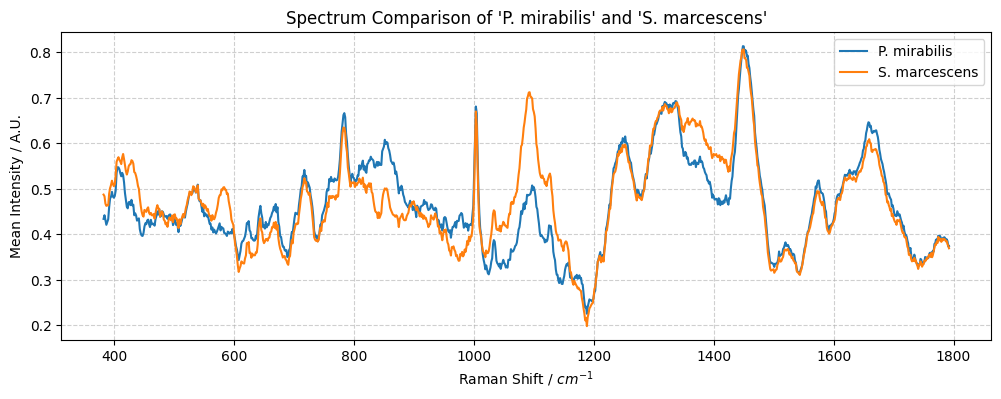

In [ ]:
compare_mean_spectrum('E. faecalis 2',
           'E. faecium',
           X_data=X_train_final,
           y_data=y_train,
           species_labels_list=species_labels,
           wavenumbers_data=wavenumbers)


compare_mean_spectrum('P. mirabilis',
           'S. marcescens',
           X_data=X_train_final,
           y_data=y_train,
           species_labels_list=species_labels,
           wavenumbers_data=wavenumbers)

**Summary of model_2:**

From the figure above, the difference between those species are too subtle (peak positions) that simple model_2 with just a Conv_1d layer struggle to distinguish, thefore a more powerful model with more feature extraction layers (Conv1D) is needed for the task.

Overfitting is observed in model 2, therefore, regularization method such as BatchNormalization and Dropout layer will be added in model_3.

**Using deeper model for training - model_3**

In [ ]:
tf.random.set_seed(42)

In [ ]:
# Create a model
model_3 = tf.keras.Sequential([
    # Convolutional base to extract features
    tf.keras.layers.Conv1D(filters = 40, kernel_size = 10, strides = 2, padding = "same", activation = "relu", input_shape = INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(filters = 80, kernel_size = 10, strides = 2, padding = "same", activation = "relu"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 10, strides = 2, padding = "same", activation = "relu"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(filters = 320, kernel_size = 10, strides = 2, padding = "same", activation = "relu"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(filters = 640, kernel_size = 10, strides = 1, padding = "same", activation = "relu"),
    tf.keras.layers.BatchNormalization(),

    # Flatten 2D features into 1D
    tf.keras.layers.Flatten(),

    # Classifier head to make a prediction
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(30, activation = "softmax")
    ])

# Add model checkpoints
model_checkpoint_3 = ModelCheckpoint('best_model_3.keras', save_best_only=True, monitor='val_loss')

# Compile the model
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        metrics = ['accuracy'])

# Summary of the model
model_3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_82 (Conv1D)              │ (None, 500, 40)        │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 500, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 250, 80)        │        32,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 250, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_84 (Conv1D)              │ (None, 125, 160)       │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 125, 160)       │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 63, 320)        │       512,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 63, 320)        │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 63, 640)        │     2,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 63, 640)        │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 40320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │     4,032,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,761,730 (25.79 MB)

 Trainable params: 6,759,250 (25.78 MB)

 Non-trainable params: 2,480 (9.69 KB)

In [ ]:
history_3 = model_3.fit(X_train_final,
             y_train_final,
             epochs = 20,
             batch_size = 10,
             validation_data = (X_val_final, y_val_final),
             callbacks = [model_checkpoint_3],
             shuffle = True,
             verbose = 1)

Epoch 1/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.1605 - loss: 2.9699 - val_accuracy: 0.2340 - val_loss: 2.4643
Epoch 2/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1941 - loss: 2.6639 - val_accuracy: 0.3047 - val_loss: 2.3119
Epoch 3/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.2570 - loss: 2.4567 - val_accuracy: 0.3530 - val_loss: 2.0321
Epoch 4/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4407 - loss: 1.7726 - val_accuracy: 0.8377 - val_loss: 0.4927
Epoch 5/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7771 - loss: 0.6451 - val_accuracy: 0.9083 - val_loss: 0.2738
Epoch 6/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8637 - loss: 0.4029 - val_accuracy: 0.9093 - val_loss: 0.2661
Epoch 7/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8819 - loss: 0.3471 - val_accuracy: 0.9253 - val_loss: 0.2365
Epoch 8/20
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8905 - loss: 0

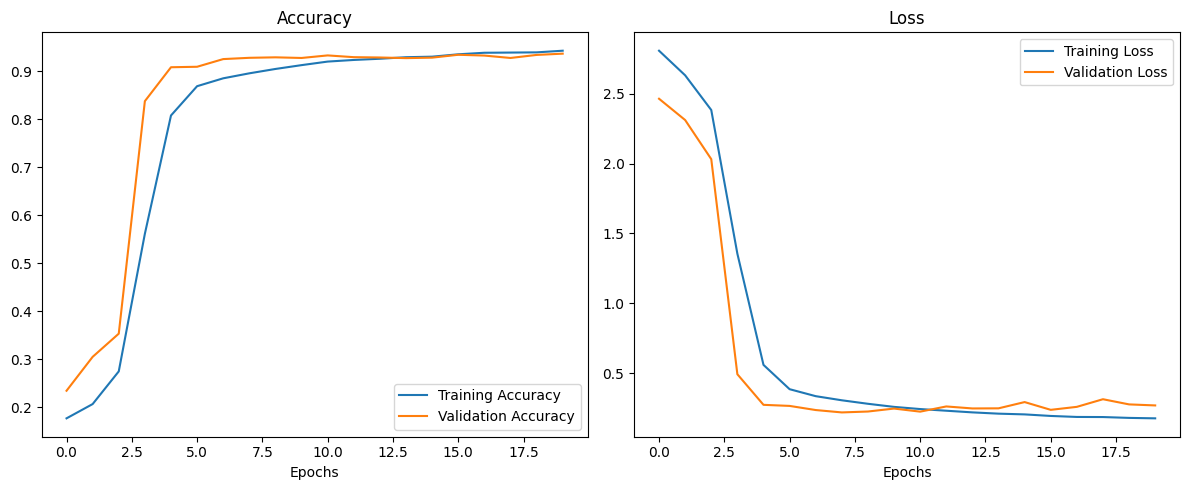

In [ ]:
plot_loss_curves(history_3)

**Evaluate model_3 on test data**

In [ ]:
# Evaluate the model after fine-tuning
best_model_3 = tf.keras.models.load_model('best_model_3.keras')
y_pred_3 = best_model_3.predict(X_test_final)

# Convert predictions from probabilities to class labels
y_pred_labels_3 = tf.argmax(y_pred_3, axis=1)

accuracy_3 = accuracy_score(y_test, y_pred_labels_3)
print(f"accuracy of model_3: {accuracy_3:.3f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
accuracy of model_3: 0.537


**Make confusion matrix**

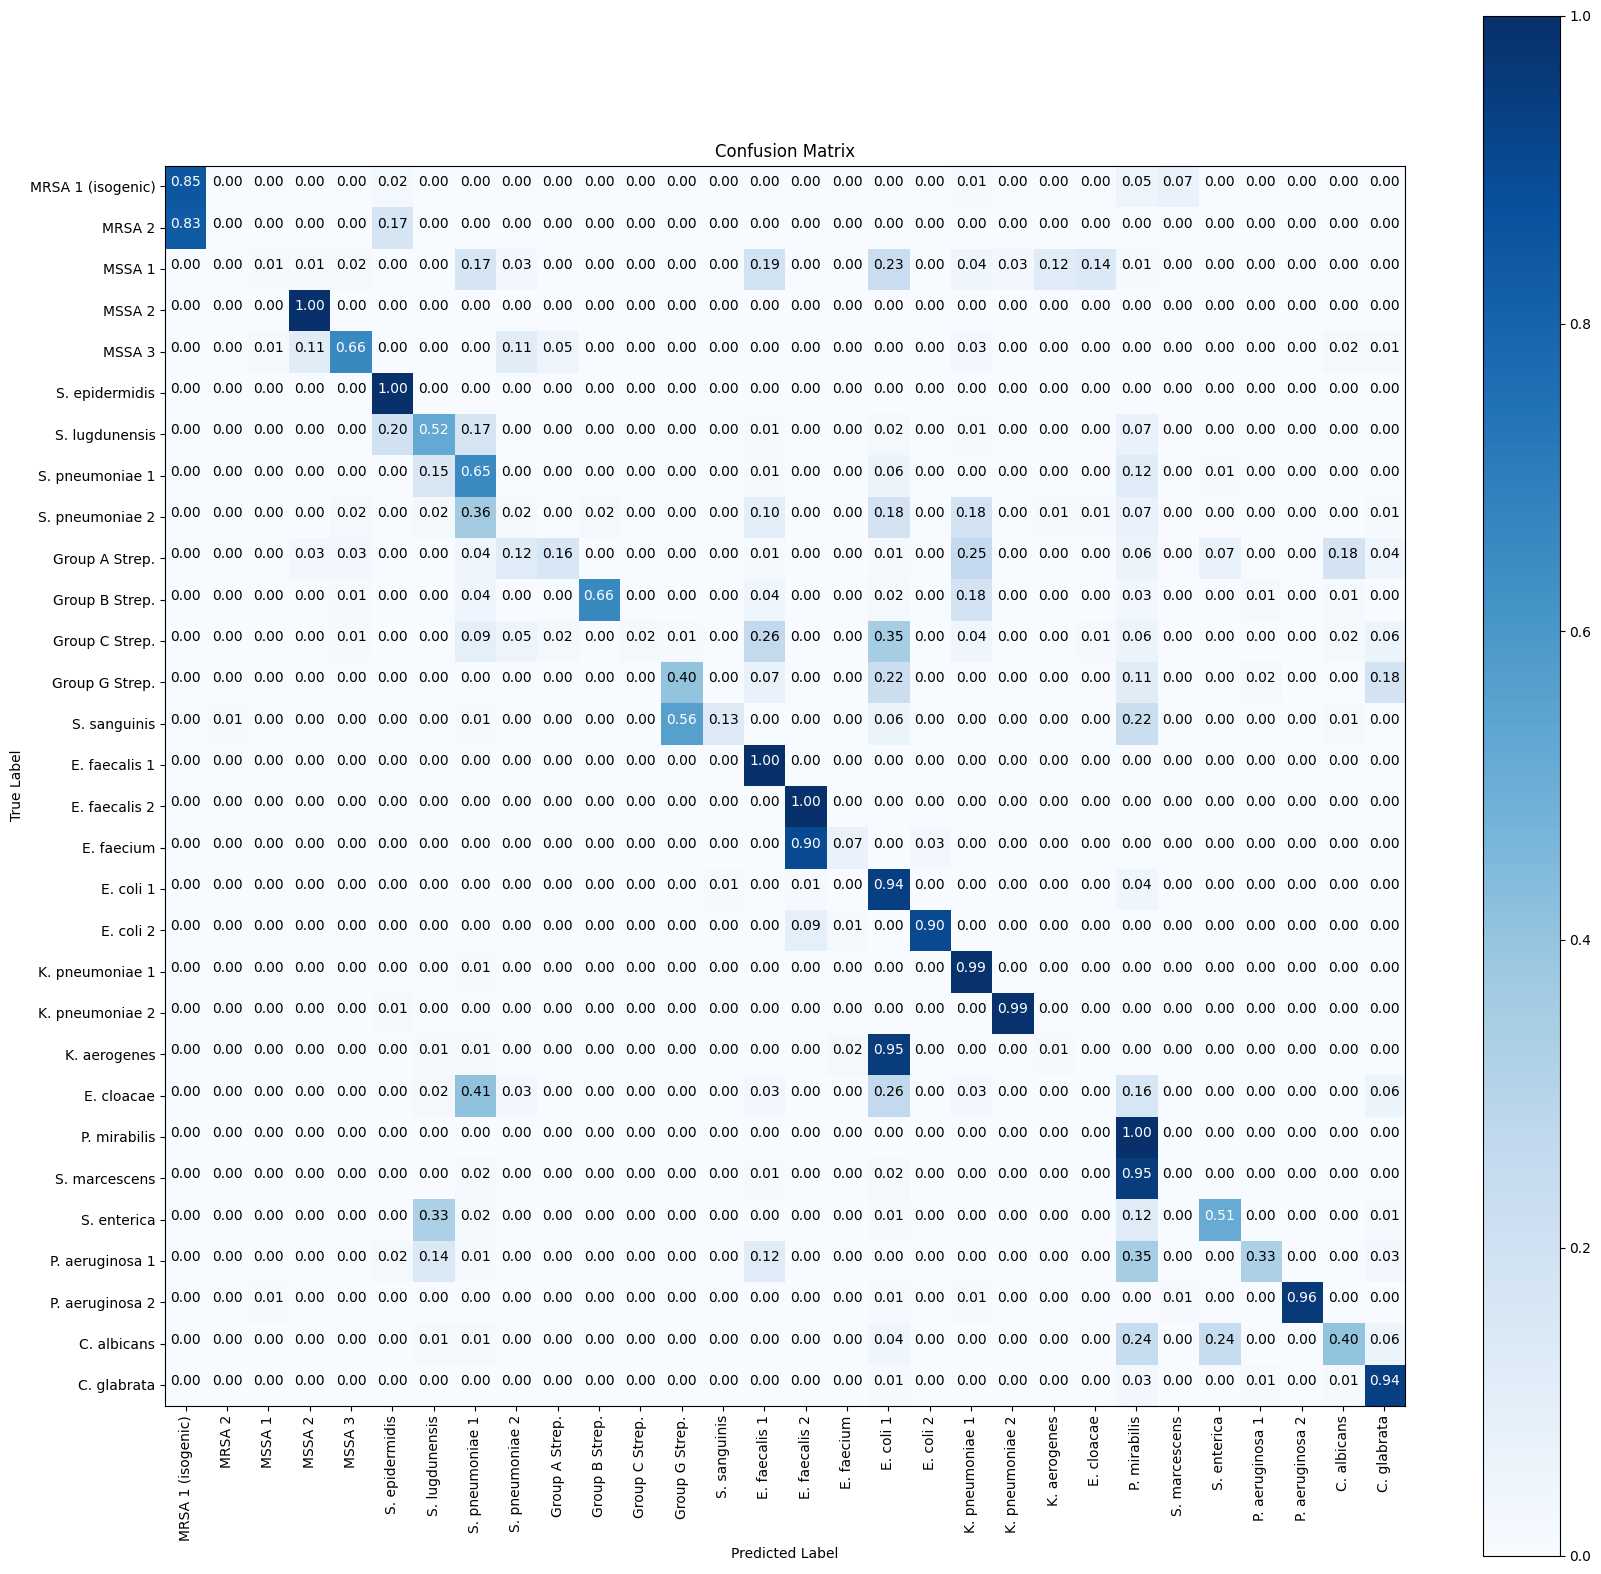

In [ ]:
make_confusion_matrix(y_test, y_pred_labels_3, classes=species_labels, normalize=True, figsize=(20,20), text_size = 10)

**Summary of model_3**

Model_3 with deeper layers achieved an accuracy of 0.537, which is not significantly better than the shallower model_2 with a acuuracy of 0.488. Therefore, architectural changes alone were insufficient and that adapting to the data distribution shift via fine-tuning further is needed.

### Stage 1 - Fine-tuning: Calibration for Equipment Drift

**Uisng X_finetune to adjust the varying optical quality (equipment drift) during measurement**

This step performs the first of two transfer learning stages: a calibration fine-tuning. Our pre-trained model_3 was trained on an extensive dataset under one set of optical conditions. To account for a subsequent data distribution shift caused by "equipment drift" (a slight degradation in optical quality over time), we adapt the model using the X_finetune dataset. This crucial calibration ensures the model's learned features remain accurate under the newer measurement conditions before proceeding to the final evaluation or the next transfer learning stage with clinical data.



**Load Pre-trained Model and Freeze Layers**

Here, we implement a classic transfer learning strategy. The convolutional layers, which have learned to be powerful feature extractors, are kept frozen to preserve their general knowledge. We then unfreeze only the classifier head (the final dense layers) to retrain it on our new, specific dataset.

In [ ]:
# Load the pre-trained model previously saved
model_finetune = tf.keras.models.load_model('best_model_3.keras')

# Loop through all layers and freeze them, except for the last two
for layer in model_finetune.layers[:]:
    layer.trainable = True

# Check the status of the layers to confirm the change was successful
print("\n--- Model Layers Trainability ---")
for layer in model_finetune.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")


--- Model Layers Trainability ---
conv1d_82: Trainable = True
batch_normalization_90: Trainable = True
conv1d_83: Trainable = True
batch_normalization_91: Trainable = True
conv1d_84: Trainable = True
batch_normalization_92: Trainable = True
conv1d_85: Trainable = True
batch_normalization_93: Trainable = True
conv1d_86: Trainable = True
batch_normalization_94: Trainable = True
flatten_25: Trainable = True
dense_46: Trainable = True
dropout_21: Trainable = True
dense_47: Trainable = True


**Compile and Fine-Tune the Model**

To perform the calibration step, the finetune dataset is split into training and validation subsets. The model is fine-tuned on the training portion to adapt to the data distribution shift caused by equipment drift. The validation set is crucial for monitoring this process and preventing overfitting.

Small learning rate is used for fine-tuning since the pretrained modelweights contain rich, hierarchical feature representations—from simple edges and textures in early layers to complex object parts in later layers. A large learning rate would cause drastic updates to these carefully tuned weights, effectively erasing this valuable knowledg, also know as "catastrophic forgetting".

In [ ]:
# Compile the model with a low learning rate for fine updata
FT_LEARNING_RATE = 5e-5
model_finetune.compile(loss='categorical_crossentropy',
           optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LEARNING_RATE),
           metrics=['accuracy'])

# Create a model ceckpoint
model_checkpoint_finetune = ModelCheckpoint('best_model_finetune.keras', save_best_only=True, monitor='val_loss')

# Fit the model
print("\n--- Starting Fine-Tuning ---")
history_finetune = model_finetune.fit(
    X_ft_train_final,
    y_ft_train_final,
    epochs=400,
    shuffle = True,
    validation_data=(X_ft_val_final, y_ft_val_final),
    callbacks = [model_checkpoint_finetune],
    verbose=0)


--- Starting Fine-Tuning ---


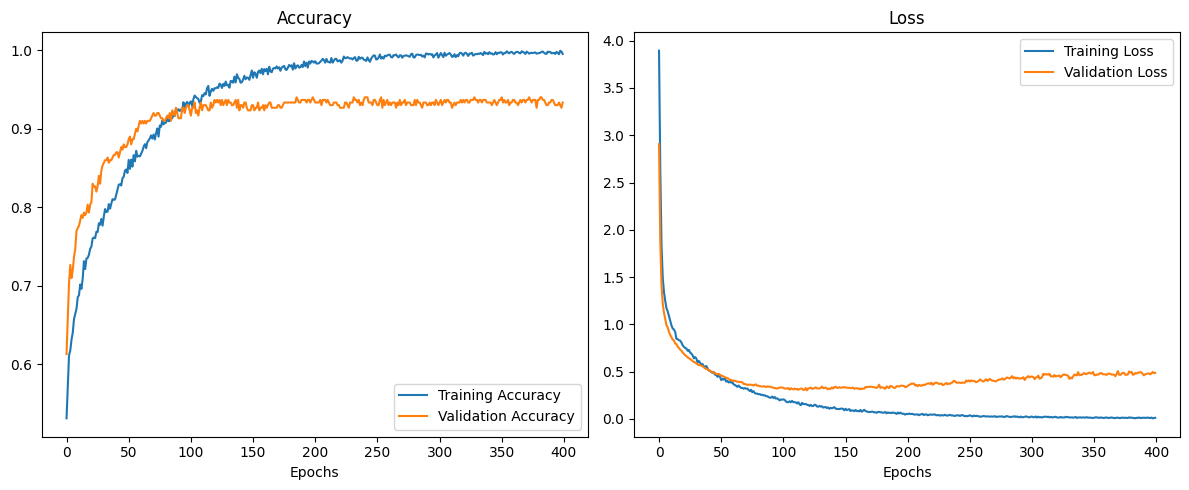

In [ ]:
plot_loss_curves(history_finetune)

**Evaluate the model's performance**

In [ ]:
# Evaluate the model after fine-tuning
print("Evaluating the calibrated model on the test set...")

# Make predictions on the test data
best_model_finetune = tf.keras.models.load_model('best_model_finetune.keras')
y_pred_finetune = best_model_finetune.predict(X_test_final)

# Convert predictions from probabilities to class labels
y_pred_labels_finetune = tf.argmax(y_pred_finetune, axis=1)

# Note: The original y_test labels are not one-hot encoded, so we use them directly.
test_accuracy_finetuned = accuracy_score(y_test, y_pred_labels_finetune)

print(f"\nAccuracy of finetune_model on Test Set after calibration: {test_accuracy_finetuned:.3f}")

Evaluating the calibrated model on the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Accuracy of finetune_model on Test Set after calibration: 0.843


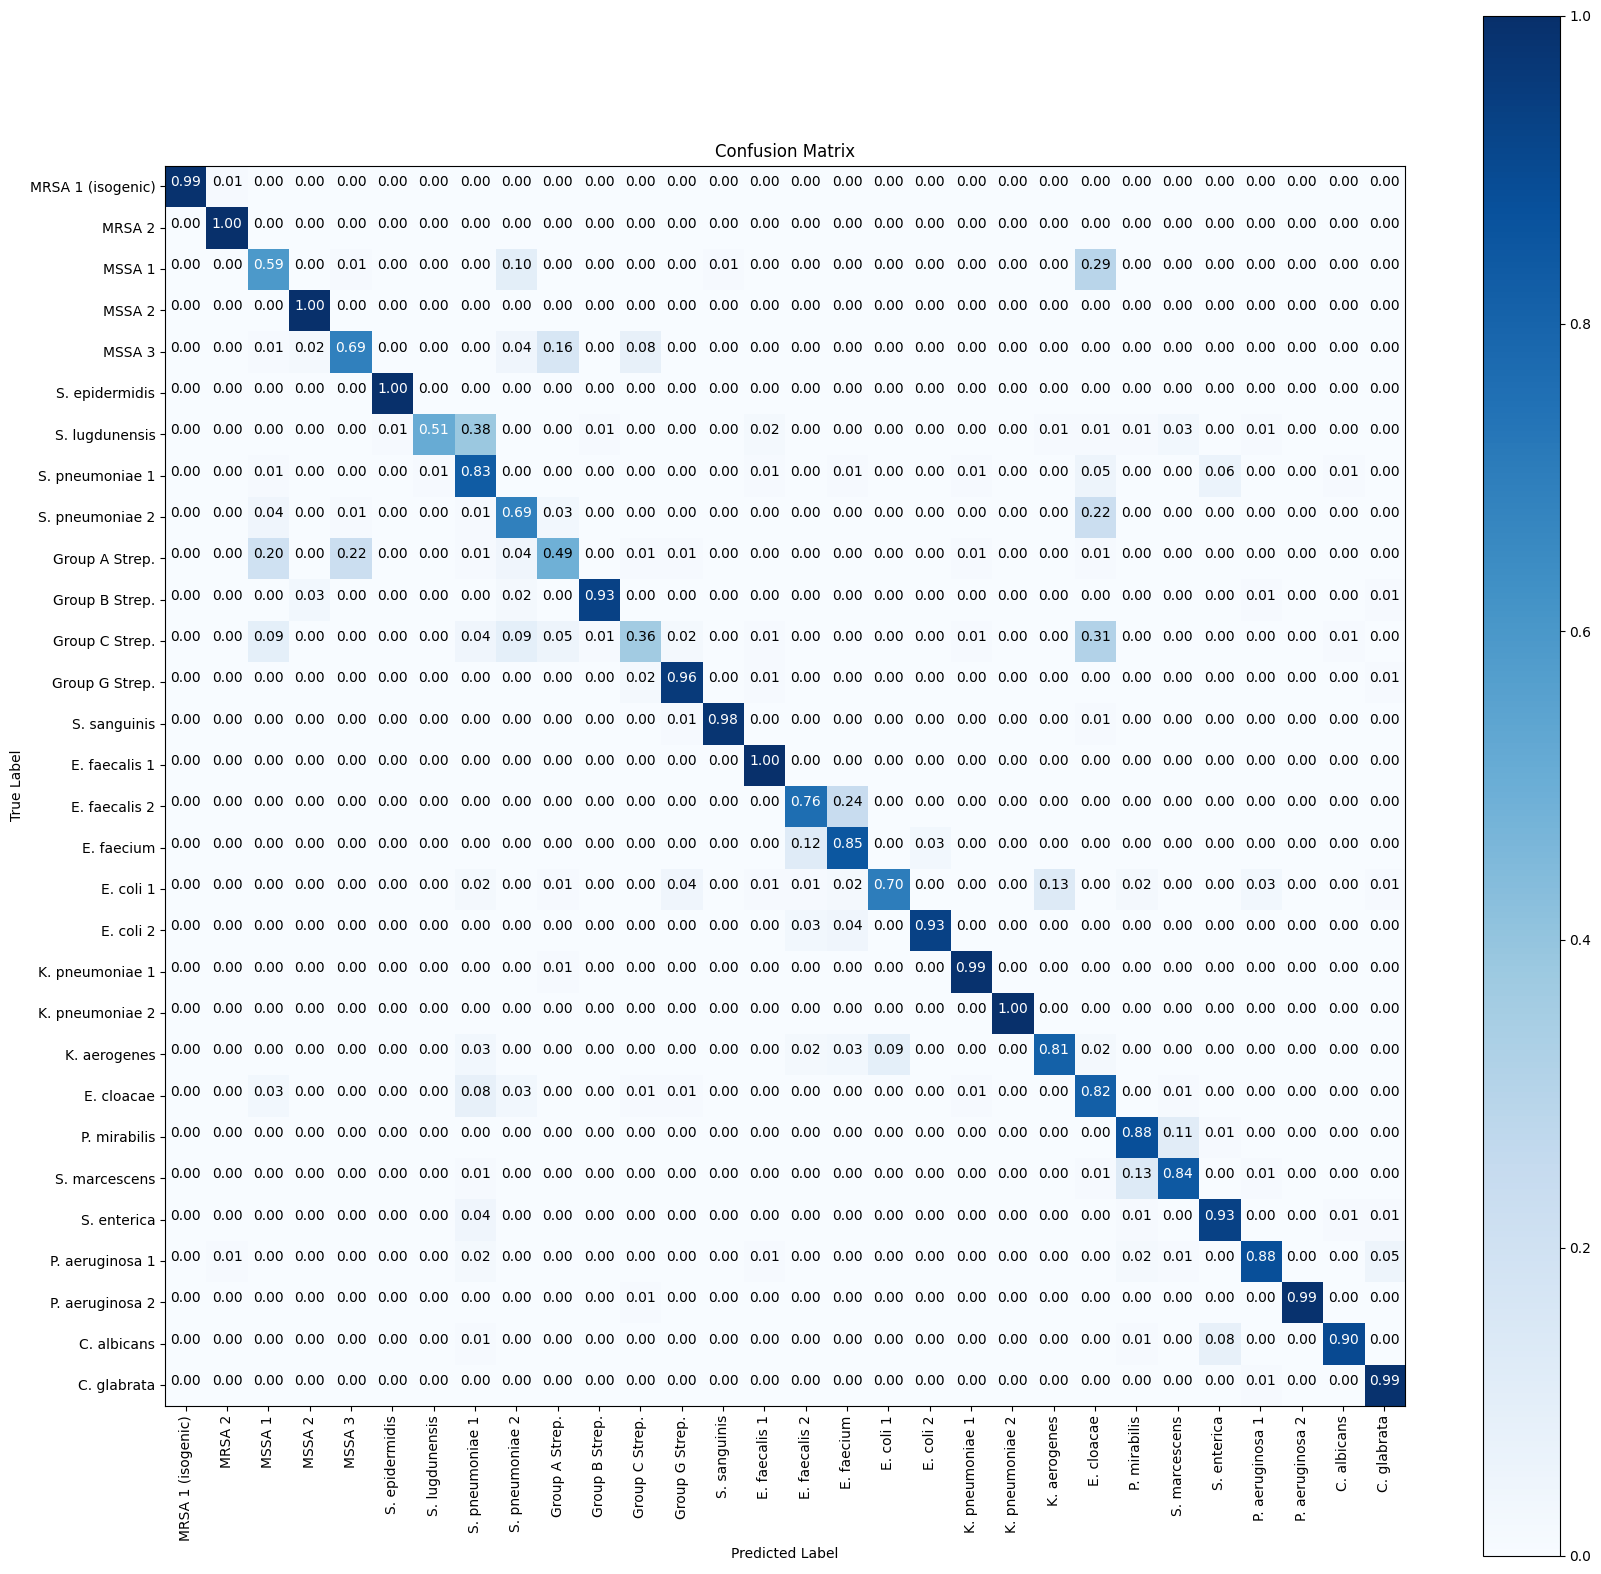

In [ ]:
# Generate a confusion matrix to see the detailed performance
make_confusion_matrix(y_test,
           y_pred_labels_finetune,
           classes=species_labels,
           figsize=(20, 20),
           text_size = 10,
           normalize = True)

### Stage 2 -  Transfer Learning: Adaptation the model on Clinical Data


**Using clinical2018 dataset to account for real clinical data**

This final stage specializes our calibrated model for the complexities of a real-world clinical environment. We will perform a second round of transfer learning using the clinical2018 dataset.

- Objective: Adapt the model, previously trained on clean lab data, to handle the increased noise and variability inherent in clinical samples.

- Method: Use the calibrated model as a feature extraction base. The original 30-class classifier head will be removed and replaced with a new, 5-class head to match the clinical dataset.

- Process: The feature extraction base will be frozen to preserve its powerful, learned features. Only the new 5-class classifier head will be trained, allowing the model to efficiently learn to map these features to the specific clinical species.

The five classes in 2018 clinical dataset:

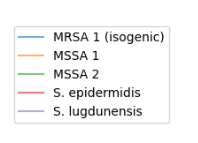

**Use model_finetune as base model and add new classifier head**

In [ ]:
# Load your best-performing fine-tune model
# I've renamed the variable for clarity
pretrained_30_class_model = tf.keras.models.load_model('best_model_finetune.keras')

# Create a new Sequential model to serve as your base
base_model = tf.keras.Sequential(name="feature_extraction_base")

# Add layers to base model except the last five (classifier head: Flatten, Dense, Dropout, Dense, Dropout)
for layer in pretrained_30_class_model.layers[:-5]:
  base_model.add(layer)

# Freeze the entire base model so its weights are not updated
base_model.trainable = False

# Add new 5-class head
new_head = tf.keras.Sequential([
    # The input shape will be inferred automatically
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation="softmax") # 5-class output
    ], name="new_classifier_head")

# Combine into the final model
model_clinical2018 = tf.keras.Sequential([base_model, new_head])

# It's good practice to build the model by specifying the input shape
model_clinical2018.build(input_shape=(None, 1000, 1)) # (batch_size, steps, features)

model_clinical2018.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extraction_base         │ (None, 63, 640)        │     2,724,040 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_classifier_head             │ (None, 5)              │     4,032,605 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,756,645 (25.77 MB)

 Trainable params: 4,032,605 (15.38 MB)

 Non-trainable params: 2,724,040 (10.39 MB)

In [ ]:
# Compile the new model
TL_LEARNING_RATE = 1e-4
model_clinical2018.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=TL_LEARNING_RATE),
              metrics=['accuracy'])

# Create a model checkpoint
model_checkpoint_clinical2018 = ModelCheckpoint('best_model_clinical2018.keras', save_best_only=True, monitor='val_loss')

# Fit the model
print("\n--- Starting Transfer-Learning ---")
history_clinical2018_finetune = model_clinical2018.fit(
    X_2018clinical_tune_final,
    y_2018clinical_tune_final,
    epochs=50,
    shuffle = True,
    validation_data=(X_2018clinical_val_final, y_2018clinical_val_final),
    callbacks = [model_checkpoint_clinical2018],
    verbose=0)


--- Starting Transfer-Learning ---


**Evaluate on model's performance**

In [ ]:
# Create a function to remap the labels in y_2018clinical_test (0,2,3,5,6) -> (0,1,2,3,4)
def remap_labels_sklearn(labels):
  """Remaps an array of integer labels to a 0-indexed sequential range."""
  le = LabelEncoder()
  remapped_labels = le.fit_transform(labels)
  print(f"Original unique classes found: {le.classes_}")
  return remapped_labels

# Remap y_2018clinical_test
y_2018clinical_test_remapped = remap_labels_sklearn(y_2018clinical_test)

print("\nOriginal labels (first 20):", y_2018clinical_test[:20])
print("Remapped labels (first 20):", y_2018clinical_test_remapped[:20])

Original unique classes found: [0 2 3 5 6]

Original labels (first 20): [2 5 5 6 3 6 5 5 3 0 5 3 3 0 3 0 2 0 5 5]
Remapped labels (first 20): [1 3 3 4 2 4 3 3 2 0 3 2 2 0 2 0 1 0 3 3]


In [ ]:
# Evaluate the model after fine-tuning
print("Evaluating the calibrated model on the test set...")

# Make predictions on the test data
y_pred_clinical2018 = model_clinical2018.predict(X_2018clinical_test_final)

# Convert predictions from probabilities to class labels
y_pred_labels_clinical2018 = tf.argmax(y_pred_clinical2018, axis=1)

# Note: The original y_test labels are not one-hot encoded, so we use them directly.
test_accuracy_clinical2018 = accuracy_score(y_2018clinical_test_remapped, y_pred_labels_clinical2018)

print(f"\nAccuracy of model on Test Set after calibration: {test_accuracy_clinical2018:.3f}")

Evaluating the calibrated model on the test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

Accuracy of model on Test Set after calibration: 0.976


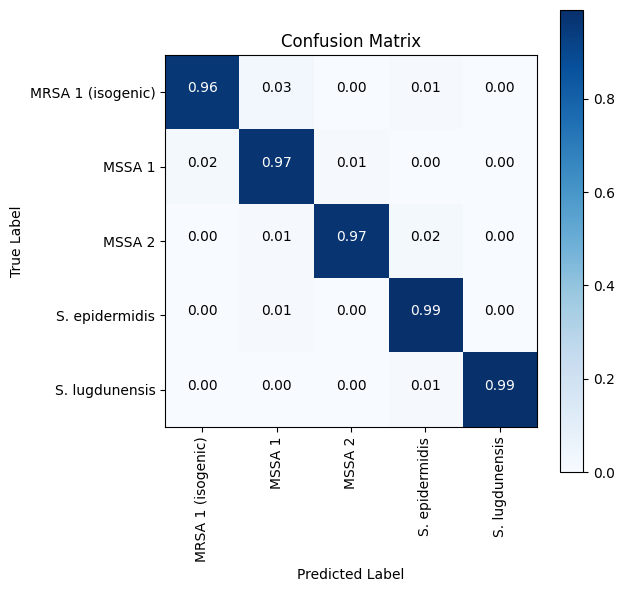

In [ ]:
clinical_2018_labels = [
          'MRSA 1 (isogenic)',
          'MSSA 1',
          'MSSA 2',
          'S. epidermidis',
          'S. lugdunensis'
          ]

make_confusion_matrix(y_2018clinical_test_remapped, y_pred_labels_clinical2018, classes = clinical_2018_labels, normalize = True, figsize = (6,6), text_size = 10)

**MRSA:** Stands for **Methicillin-Resistant** Staphylococcus aureus. It's a strain of the S. aureus bacterium that has developed resistance to methicillin and other common antibiotics like penicillin and amoxicillin. This resistance makes MRSA infections much more difficult to treat, earning it the name "superbug."

**MSSA:** Stands for **Methicillin-Susceptible** Staphylococcus aureus. This is the more common form of the S. aureus bacterium. It is "susceptible" to, or can be killed by, methicillin and other standard antibiotics.

As the paper indicates, consequences for misdiagnosing MRSA as MSSA are often more severe than the reverse misdiagnosis since it will results in ineffective tratements.

## **Model Interpretability: Validating with Grad-CAM**

To ensure our model is not just a "black box," Grad-CAM is used. This technique generates a heatmap that we overlay on the Raman spectrum. By visualizing the overlapping parts, we can determine if the model is focusing on significant peaks (the real signal) or on irrelevant noise. This allows us to validate the model's decision-making process, building trust that it is identifying bacteria based on scientifically meaningful features.

In [ ]:
def generate_grad_cam_1d(model, spectrum, class_index, layer_name):
    """
    Generates a 1D Grad-CAM heatmap using model splitting and correct
    1D interpolation for resizing.

    Args:
        model (tf.keras.Model): The built and trained Keras model.
        spectrum (np.ndarray): The input spectrum, shape (1, 1000, 1).
        class_index (int): The index of the target class.
        layer_name (str): The name of the last convolutional layer.

    Returns:
        np.ndarray: The generated heatmap, correctly resized to the original length.
    """
    # 1: --------- Splitting the Model in Two ---------

    # from the input layer right up to the output of the last convolutional layer
    feature_extractor = tf.keras.Model(model.inputs, last_conv_layer.output)

    # everything after the last convolutional layer
    last_conv_layer = model.get_layer(layer_name)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    start_layer_index = [layer.name for layer in model.layers].index(layer_name) + 1

    x = classifier_input
    for i in range(start_layer_index, len(model.layers)):
        x = model.layers[i](x)
    classifier = tf.keras.Model(classifier_input, x)

    # 2. --------- Calculating "Importance" with Gradients ---------

    # TensorFlow will track all calculations inside this block
    with tf.GradientTape() as tape:
        features = feature_extractor(spectrum)
        tape.watch(features)
        predictions = classifier(features)
        loss = predictions[:, class_index]

    # How much does the score for target class (loss) change if slightly changing each value in the features
    grads = tape.gradient(loss, features)

    # 3. --------- Creating the heatmap ---------

    # Calculate average gradient, turning it into a single importance score
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    features = features[0]

    # Performs a weighted sum. Multiplies each features by its importance score (pooled_grads) and adds them all togethe
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # We only care about features that have a positive influence on the decision, so we discard any negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap so its values are between 0 and 1, making it easy to visualize with colors
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)

    # Convert heatmap tensor to a NumPy array for interpolation
    heatmap_np = heatmap.numpy()

    # Create x-coordinates for the original (small) and target (large) heatmaps
    original_x = np.linspace(0, 1, num=heatmap_np.shape[0])
    target_x = np.linspace(0, 1, num=spectrum.shape[1])

    # Interpolate the heatmap values across the new, larger x-coordinates
    resized_heatmap = np.interp(target_x, original_x, heatmap_np)

    return resized_heatmap

In [ ]:
# Rebuild the model
rebuilt_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1000, 1)),
    tf.keras.layers.Conv1D(filters=40, kernel_size=10, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=80, kernel_size=10, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=160, kernel_size=10, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=320, kernel_size=10, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=640, kernel_size=10, strides=1, padding="same", activation="relu", name='conv1d_rebuilt'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(30, activation="softmax")
])
rebuilt_model.load_weights('best_model_finetune.keras')
print("Model rebuilt and weights loaded.")

Model rebuilt and weights loaded.


In [ ]:
# Get Grad Cam for a randomly selected spectrum in a randomly selected class

def random_spectrum_grad_cam():
  # 1. Randomly select a species index (a number from 0 to 29)
  random_species_index = random.randint(0, 29)
  print(f"Randomly selected species: '{species_labels[random_species_index]}'")

  # 2. Find all indices in the test set that belong to this species
  matching_indices = np.where(y_test == random_species_index)[0]

  # 3. Randomly choose one of those indices
  chosen_index = random.choice(matching_indices)
  print(f"Chose spectrum at index: {chosen_index}")

  # 4. Use this final index to select the spectrum and its true label
  #    Slicing this way [index:index+1] keeps the batch dimension for the model
  sample_spectrum = X_test_final[chosen_index : chosen_index + 1]
  true_label_index = y_test[chosen_index]

  # Run prediction on the randomly selected sample
  preds = rebuilt_model.predict(sample_spectrum)
  predicted_class_index = np.argmax(preds[0])

  print(f"\nTrue Label: {species_labels[true_label_index]}")
  print(f"Predicted Label: {species_labels[predicted_class_index]} with confidence {preds[0][predicted_class_index]:.2f}\n")

  # Generate the heatmap
  heatmap = generate_grad_cam_1d(rebuilt_model,
                  sample_spectrum,
                  predicted_class_index,
                  'conv1d_rebuilt')

  # Plot the results
  plt.figure(figsize=(18, 6))
  plt.plot(wavenumbers, np.squeeze(sample_spectrum), color='blue', label='Original Spectrum')
  plt.imshow(np.expand_dims(heatmap, axis=0),
              extent=(wavenumbers.min(), wavenumbers.max(),
              np.min(sample_spectrum), np.max(sample_spectrum)),
              cmap='inferno',
              aspect='auto',
              alpha=0.6)
  plt.colorbar(label='Model Attention (Grad-CAM)')
  plt.xlabel("Raman Shift / $cm^{-1}$")
  plt.ylabel("Intensity / A.U.")
  plt.title(f"Grad-CAM for Prediction: '{species_labels[predicted_class_index]}'")
  plt.legend()
  plt.show()

**Visualize with heatmap**

By applying Grad-Cam, we can visualize which part (feature) of a Raman spectrum is being used for a model for classificaion.

Randomly selected species: 'K. aerogenes'
Chose spectrum at index: 2143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

True Label: K. aerogenes
Predicted Label: K. aerogenes with confidence 1.00



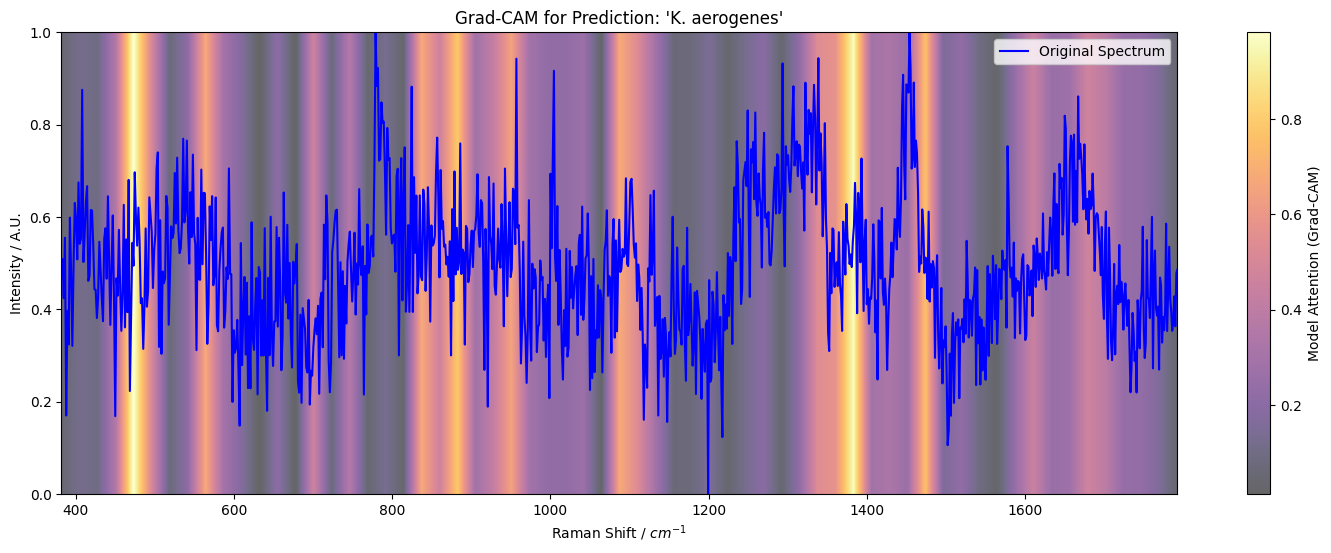

In [ ]:
random_spectrum_grad_cam()

##**Conclusion**

1. This project successfully developed an end-to-end deep learning pipeline to classify 30 bacterial species from Raman spectra, culminating in a final model that achieved 97.6% accuracy on a 5-class clinical dataset.

2. The project began by establishing a PCA+SVC baseline model, which recorded an accuracy of 41.4%. Following this, a progressively deeper 1D CNN was developed. The crucial breakthrough came from a two-stage transfer learning approach. The first stage calibrated the model for "equipment drift," boosting test accuracy significantly to 84.3%. The second stage adapted this calibrated model for a specialized clinical task, resulting in the final high-performance classifier.

3. Finally, model interpretability was confirmed using Grad-CAM, which verified that the model's classifications were based on scientifically relevant spectral peaks and not irrelevant noise. This work demonstrates a robust, methodical approach to building a specialized and highly accurate classifier for complex, real-world spectroscopic data.